In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.io.fits as fits
import astropy.constants as const
from scipy.stats import sigmaclip as sigmaclip
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tnrange
import pandas as pd
import PyAstronomy.pyasl as pyasl
import h5py
import batman
import math
import barycorrpy

from function import mask_pix
from function import high_pass_filter
from function import med_n_lim
from function import solve_E

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## Data Reduction

In [3]:
class Data_Reduction():

    def __init__(self,spectrum_path,Oliva_OH_path,Oliva_nonOH_path,Rousselot_OH_path,
                 sum_order,bad_frame,bad_order,telluric_order,ref_cont,
                 maskpix_value,resolution,edge_pix,factor_emission,factor_telluric,factor_outliers,sigma_threshold,
                 threshold_heavy_low,threshold_nonheavy_low,threshold_heavy_ratio,threshold_nonheavy_ratio,
                 binmedfil,bingauss,continuum_minimum,
                 **kwargs):
        
        self.data_path = spectrum_path
        self.sum_order = sum_order
        self.bad_frame = bad_frame
        self.bad_order = bad_order
        self.tel_order = telluric_order
        self.thold_hvy_low = threshold_heavy_low
        self.thold_nhvy_low = threshold_nonheavy_low
        self.thold_hvy_rat = threshold_heavy_ratio
        self.thold_nhvy_rat = threshold_nonheavy_ratio
        self.ref_cont = ref_cont
        self.maskpix_val = maskpix_value
        self.edge_pix = edge_pix
        self.sig = sigma_threshold
        self.res = resolution
        self.fac_emis = factor_emission
        self.fac_tel = factor_telluric
        self.fac_out = factor_outliers
        self.binmedfil = binmedfil
        self.bingauss = bingauss
        self.min_cont = continuum_minimum
        self.OH_oliva = Oliva_OH_path
        self.nonOH_oliva = Oliva_nonOH_path
        self.OH_rousselot = Rousselot_OH_path
        self.data_info = {}
        self.__dict__.update(kwargs)

    # function for masking emission wavelengths
    def emission(self,wl,emis):
        wv = np.array(emis)[(wl[0] < emis) * (wl[-1] > emis)]
        mask = (np.prod(np.abs(wl - wv[:,np.newaxis]) > wv[:,np.newaxis]/self.res*self.fac_emis,axis=0)) == 1 # masking regions around the emission line bounded by eta*(lambda/R)
        return mask

    # function for opening and reading the spectrum FITS file
    def data_prep(self):

        dat_file = []
        lst = os.listdir(self.data_path)
        lst.sort()
        for x in lst:
            if not x.startswith('.') and x.endswith('.fits'):
                dat_file.append(x)

        # exclude bad frames
        [dat_file.pop(frame) for frame in self.bad_frame]

        flux,wave,error = [],[],[]
        exptime,snr,airmass,mjd,jd,bjd,rvcor,seeing,humid,temp = [],[],[],[],[],[],[],[],[],[]

        for idx,frame in enumerate(dat_file):
            spec = fits.open(str(self.data_path)+str(frame))

            flux_temp,wave_temp,error_temp = [],[],[]
            for order in range(self.sum_order):
                flux_temp.append(spec[1].data[order]) # flux
                wave_temp.append(spec[4].data[order]) # wavelength
                error_temp.append(spec[3].data[order]) # photon(+shot) noise
            flux.append(flux_temp)
            wave.append(wave_temp)
            error.append(error_temp)

            airmass.append(spec[0].header["AIRMASS"]) # airmass at the observation start
            exptime.append(spec[0].header["EXPTIME"]) # exposure time
            mjd.append(spec[0].header['HIERARCH CARACAL MJD-OBS']) # MJD at the observation start
            rvcor.append(spec[0].header['HIERARCH CARACAL BERV']) # barycentric correction in to observer rest-frame
            bjd.append(spec[0].header['HIERARCH CARACAL BJD']) # BJD at the observation start
            jd.append(spec[0].header['HIERARCH CARACAL JD']) # JD at the middle of observation
            humid.append(spec[0].header['HIERARCH CAHA GEN AMBI RHUM']) # relative humidity
            temp.append(spec[0].header['HIERARCH CAHA GEN AMBI TEMPERATURE']) # ambient temperature

            if frame.endswith("A.fits"):
                snr_temp = []
                for i in range(self.sum_order):
                    snr_temp.append(spec[0].header["HIERARCH CARACAL FOX SNR "+str(i)]) # star SNR per pixel from CARACAL
                snr.append(snr_temp)
            elif frame.endswith("B.fits"):
                snr_temp = []
                for i in range(self.sum_order):
                    snr_temp.append(spec[0].header["HIERARCH CARACAL LXT SNR "+str(i)]) # sky SNR per pixel from CARACAL
                snr.append(snr_temp)

        flux,wave,error = np.array(flux),np.array(wave),np.array(error)
        print(flux.shape)
        self.tot_init = flux.shape[2]*flux.shape[1]

        flux_star = np.zeros((flux.shape[1],flux.shape[0],flux.shape[2])) # order x frame x wavelength
        wave_star = flux_star.copy()
        error_star = flux_star.copy()
        for order in range(flux_star.shape[0]):
            flux_star[order] = flux[:,order,:]
            wave_star[order] = wave[:,order,:]
            error_star[order] = error[:,order,:]

        ref_spec = np.argmax(np.mean(snr,axis=1)) # reference spectrum taken as spectrum with highest mean SNR (over orders)
        self.ref_spec = ref_spec

        print('Mean SNR over all frames and orders: '+str(np.mean(snr)))
        print('Frame with the highest SNR: '+str(np.argmax(np.mean(snr,axis=1)))+' ('+str(dat_file[np.argmax(np.mean(snr,axis=1))])+')')

        if self.__dict__['plot_prep']:

            # plot humidity and airmass
            fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
            ax1.scatter(np.arange(len(bjd)),humid)
            ax1.set_title('Humidity')
            ax2.scatter(np.arange(len(bjd)),airmass)
            ax2.set_title('Airmass')
            print('Average humidity is '+str(np.mean(humid)))
            plt.show()
            plt.clf()

            plt.figure(figsize=(15,10))

            # plot average SNR over frames for every orders
            plt.subplot(211)
            plt.scatter(np.arange(len(snr[0])),np.mean(snr,axis=0))
            plt.plot(np.mean(snr,axis=0))
            plt.axhline(y=50,ls='--',lw=1)
            plt.ylabel("snr")
            plt.xlabel("order")
            plt.title('SNR')

            # plot average SNR over orders for every frames
            plt.subplot(212)
            plt.scatter(np.arange(len(snr)),np.mean(snr,axis=1))
            plt.plot(np.mean(snr,axis=1))
            plt.ylabel("snr")
            plt.xlabel("frame")
            plt.title('SNR')

            plt.show()
            plt.clf()

            plt.figure(figsize=(15,5),dpi=300)
            for order in range(len(flux_star)):
                if order not in self.bad_order:
                    plt.plot(wave_star[order][ref_spec],flux_star[order][ref_spec],color='black',lw=1)
                else:
                    plt.plot(wave_star[order][ref_spec],flux_star[order][ref_spec],color='gray',lw=1)
                    # plt.fill_betweenx(np.arange(0.1),wave_star[order][41][0],wave_star[order][41][-1],color='green',alpha=0.4,edgecolor='none')
                
            plt.ylabel('Arbitrary flux')
            plt.xlabel(r'Wavelength ($\AA$)')
            plt.show()
            plt.clf()

        self.data_info['airmass'] = np.asarray(airmass)
        self.data_info['humid'] = np.asarray(humid)
        self.data_info['exptime'] = np.asarray(exptime)
        self.data_info['SNR'] = np.asarray(snr)
        self.data_info['MJD'] = np.asarray(mjd)
        self.data_info['JD'] = np.asarray(jd)
        self.data_info['BJD'] = np.asarray(bjd)
        self.data_info['RV_cor'] = np.asarray(rvcor)
        self.data_info['temperature'] = np.asarray(temp)
        return flux_star, error_star, wave_star, snr, airmass, humid, self.data_info 

    # function for reducing the data (includes normalizing, masking, and uncertainty estimation)
    def normalization_and_masking(self):

        flux_temp, error, wave, snr, airmass, humid, self.data_info = self.data_prep()
        flux = flux_temp.copy()
        ref_spec = self.ref_spec
        ref_cont = self.ref_cont

        for order in range(flux.shape[0]):

            ######################################## Spectrum normalizing ########################################
            
            # plot photon noise from CARACAL
            if self.__dict__['plot_norm']:
                plt.figure(figsize=(25,5))
                plt.subplot(131)
                plt.plot(wave[order][ref_spec],error[order][ref_spec])

                plt.subplot(132)
                plt.plot(wave[order][ref_spec],flux[order][ref_spec],linewidth=1)
                plt.plot(wave[order][ref_spec],ref_cont[0].data[order])
                plt.title("order #"+str(order))

            # normalizing with pseudo-continuum
            error[order] /= ref_cont[0].data[order]
            flux[order] /= ref_cont[0].data[order]

            for frame in range(len(flux[order])):

                # to minimize contributions from outliers and spectral lines to the median computation
                medflux = np.nanmedian(flux[order][frame][500:-500][np.argsort(flux[order][frame][500:-500])][500:])

                # removing variations between frames
                error[order][frame] /= medflux
                flux[order][frame] /= medflux

            # plot IRAF pseudo-continuum fitted using continuum task
            if self.__dict__['plot_norm']:
                plt.subplot(133)
                plt.plot(wave[order][ref_spec],flux[order][ref_spec])
                plt.show()
                plt.clf()

        ######################################## Nan and negative values masking ########################################

        if self.__dict__['print_neg']:
            for order in range(len(flux)):
                print('order '+str(order)+', negative_count = '+str(np.count_nonzero(flux[order] < 0))\
                +', nan_count = '+str(np.count_nonzero(np.isnan(flux[order]))))

        mask = ((np.prod(~np.isnan(flux),axis=1))==1) * ((np.prod(flux>=0,axis=1))==1)
        mask = np.repeat(mask[:,np.newaxis,:],repeats=[flux.shape[1]],axis=1)
        flux[~mask],error[~mask] = self.maskpix_val,np.inf

        ######################################## Removing bad orders ########################################

        flux = np.delete(flux,self.bad_order,0)
        error = np.delete(error,self.bad_order,0)
        wave = np.delete(wave,self.bad_order,0)
        self.carm_order = np.delete(np.arange(flux_temp.shape[0]),self.bad_order,0)
        self.data_info['CARMENES_order'] = self.carm_order

        ######################################## Sky emission masking ########################################

        # atlas from Oliva+ (2015)
        OH_1st,OH_2nd,nonOH = [],[],[]
        for i in range(len(self.OH_oliva)):
            OH_1st.append(self.OH_oliva[i][0]) # first OH doublet
            OH_2nd.append(self.OH_oliva[i][2]) # second OH doublet
        for i in range(len(self.nonOH_oliva)):
            nonOH.append(self.nonOH_oliva[i][0]) # non-OH emission

        # atlas from Rousselot+ (2000)
        OH_rous = []
        for i in range(len(self.OH_rousselot)):
            OH_rous.append(self.OH_rousselot[i][0])

        for order in range(len(flux)):
            
            # only use a single frame to mask as sky emission wavelengths are not changing over time
            mask = self.emission(wave[order][0],OH_1st) # OH 1st doublet
            mask *= self.emission(wave[order][0],OH_2nd) # OH 2nd doublet
            mask *= self.emission(wave[order][0],nonOH) # non-OH
            mask *= self.emission(wave[order][0],OH_rous) # atlas from Rousselot+ (2000)

            error[order][:,~mask] = np.inf
            flux[order][:,~mask] = self.maskpix_val

        if self.__dict__['plot_emis']:
            for idx,order in enumerate(self.carm_order):

                plt.figure(figsize=(20,5))
                for frame in range(len(flux[idx])):
                    plt.plot(wave[idx][frame][flux[idx][frame]!=0],flux[idx][frame][flux[idx][frame]!=0],'black',linewidth=1,alpha=1)
                plt.title(order)

                for wv in OH_1st:
                    plt.axvline(x=wv,linewidth=1,alpha=0.7,c='b')
                for wv in OH_2nd:
                    plt.axvline(x=wv,linewidth=1,alpha=0.7,c='b')
                for wv in nonOH:
                    plt.axvline(x=wv,linewidth=1,alpha=0.7,c='r')
                for wv in OH_rous:
                    plt.axvline(x=wv,linewidth=1,alpha=0.7,c='cyan')
                plt.xlim(wave[idx][ref_spec][0],wave[idx][ref_spec][-1])

                plt.show()
                plt.clf()

        ######################################## Bad regions masking (SUBJECT TO CHANGE) ########################################

        for order in range(len(self.carm_order)):

            if self.__dict__['plot_bad_reg']:
                plt.figure(figsize=(20,5))
                for frame in range(flux.shape[1]):
                    plt.scatter(wave[order][frame][flux[order][frame]!=0],flux[order][frame][flux[order][frame]!=0],s=1,c='red')
            
            mask = flux[order][0] < np.inf
            mask[:self.edge_pix] = False                                        # edge-effects of CARMENES orders (Sanchez-Lopez+ 2019)
            mask[-self.edge_pix:] = False                                       # edge-effects of CARMENES orders (Sanchez-Lopez+ 2019)
            if order == 21: mask[-1000:] = False                                # low SNR regions
            elif order == 20: mask[-350:] = False                               # low SNR regions
            elif order == 2 or order == 3 or order == 4: mask[:545] = False     # un-natural bumps in bluest parts

            error[order][:,~mask] = np.inf
            flux[order][:,~mask] = self.maskpix_val

            if self.__dict__['plot_bad_reg']:
                for frame in range(flux.shape[1]):
                    plt.scatter(wave[order][frame][flux[order][frame]!=0],flux[order][frame][flux[order][frame]!=0],s=1,c='blue')
                plt.title('order '+str(self.carm_order[order]))
                plt.show()
                plt.clf()

        ######################################## Outliers masking ########################################
        
        for idx,order in enumerate(self.carm_order):

            if self.__dict__['plot_out']:
                fig,ax = plt.subplots(1,3,figsize=(15,5))
                for frame in range(len(flux[idx])):
                    ax[0].plot(wave[idx][frame][flux[idx][frame]>0],flux[idx][frame][flux[idx][frame]>0])

            # removing cosmic rays (cosmic rays behaviour only seen in one or two frames hence it's treated differently)
            flux_temp = np.copy(flux[idx])
            for wave_bin in range(flux_temp.shape[1]):
                c = sigmaclip(flux_temp[:,wave_bin],low=self.sig,high=self.sig)[0]
                flux[idx][:,wave_bin],error[idx][:,wave_bin] = (self.maskpix_val,np.inf) if ~(np.abs(flux_temp[:,wave_bin]-np.mean(c))<self.sig*np.std(c)).all()\
                else (flux[idx][:,wave_bin],error[idx][:,wave_bin])

            # identify outliers following Gibson+ (2020) but instead using std of the residual
            wv,fl,er,maskpix = mask_pix(wave[idx],flux[idx],error[idx])
            simple_model = np.outer(np.median(fl,axis=1),np.median(fl,axis=0))/np.median(fl)
            residual = fl - simple_model
            mask = np.abs(residual[0]) > -1
            for frame in range(fl.shape[0]):
                fit = np.polyfit(wv[frame], residual[frame], 10) # fit with 10th order polynomial
                fit_coeff = np.poly1d(fit)
                fit_continuum = fit_coeff(wv[frame])
                mask *= (residual[frame] < fit_continuum + self.sig*np.std(residual[frame])) *  (residual[frame] > fit_continuum - self.sig*np.std(residual[frame]))

                if self.__dict__['plot_out'] and frame == self.ref_spec:
                    ax[1].plot(wv[frame],residual[frame])
                    ax[1].plot(wv[frame],fit_continuum)
                    ax[1].plot(wv[frame],fit_continuum+self.sig*np.std(residual[frame]))
                    ax[1].plot(wv[frame],fit_continuum-self.sig*np.std(residual[frame]))
            mask = ~mask

            # identify line center by median centering
            if True in mask:
                wv_len = wv[0,mask]
                wv_idx,wv_med,wv_temp = 0,[],[wv_len[0]]
                if len(wv_len) == 1:
                    wv_med.append(wv_len[0])
                else:
                    while wv_idx < len(wv_len)-1:
                        if wv_len[wv_idx+1]-wv_len[wv_idx] < wv_len[wv_idx]/self.res*self.fac_out/2:
                            wv_temp.append(wv_len[wv_idx+1])
                            wv_idx += 1
                        else:
                            wv_med.append(np.median(wv_temp))
                            wv_temp = [wv_len[wv_idx+1]]
                            wv_idx += 1
                    wv_med.append(wv_len[-1])

                # masking regions around outlier
                wv_med = np.array(wv_med)
                maskcen = ~((np.prod(np.abs(wv[0]-wv_med[:,np.newaxis]) > wv_med[:,np.newaxis]/self.res*self.fac_out/2,axis=0)) == 1)
                fl[:,maskcen],er[:,maskcen] = self.maskpix_val, np.inf
            else:
                fl[:,mask],er[:,mask] = self.maskpix_val, np.inf

            # assign the new value to the original array
            for frame in range(fl.shape[0]):
                error[idx][frame][maskpix==True] = er[frame]
                flux[idx][frame][maskpix==True] = fl[frame]
                
                if self.__dict__['plot_out']:
                    ax[0].set_title('order #'+str(order))
                    ax[2].plot(wave[idx][frame][flux[idx][frame]>0],flux[idx][frame][flux[idx][frame]>0])

        ######################################## Mask strong telluric absorption lines ########################################

            if self.__dict__['plot_strong_tel']:
                plt.figure(figsize=(15,3))

            wv,fl,er,maskpix = mask_pix(wave[idx],flux[idx],error[idx])

            # mask strong telluric lines
            masklow = np.min(fl,axis=0) > self.thold_hvy_low if order in self.tel_order\
                else np.min(fl,axis=0) > self.thold_nhvy_low
            
            continum = np.zeros(fl.shape)
            for frame in range(fl.shape[0]):

                # compute pseudo-continuum for strong telluric masking (see common_continuum function)
                med_fil = high_pass_filter(fl[frame][masklow],self.binmedfil)
                gauss_fil = gaussian_filter1d(med_fil,self.bingauss)
                continum[frame] = interp1d(wv[frame][masklow],gauss_fil,fill_value='extrapolate')(wv[frame])

            # masking the core of strong telluric lines (pixels with flux less than a certain threshold)
            masktel = ~((np.prod(fl>self.min_cont*continum,axis=0))==1)

            # identify line center by median centering
            if True in masktel:
                wv_len = wv[0,masktel]
                wv_idx,wv_med,wv_temp = 0,[],[wv_len[0]]
                if len(wv_len) == 1:
                    wv_med.append(wv_len[0])
                else:
                    while wv_idx < len(wv_len)-1:
                        if wv_len[wv_idx+1]-wv_len[wv_idx] < wv_len[wv_idx]/self.res*self.fac_tel/2:
                            wv_temp.append(wv_len[wv_idx+1])
                            wv_idx += 1
                        else:
                            wv_med.append(np.median(wv_temp))
                            wv_temp = [wv_len[wv_idx+1]]
                            wv_idx += 1
                    wv_med.append(wv_len[-1])

                # masking lines
                wv_med = np.array(wv_med)
                maskcen = ~((np.prod(np.abs(wv[0]-wv_med[:,np.newaxis]) > wv_med[:,np.newaxis]/self.res*self.fac_tel/2,axis=0)) == 1)
                if self.__dict__['plot_strong_tel']:
                    [plt.scatter(wv[frame][maskcen],fl[frame][maskcen],s=1,c='black') for frame in range(fl.shape[0])]
                    [plt.axvline(x=wvmask) for wvmask in wv_med]
                fl[:,maskcen],er[:,maskcen] = self.maskpix_val, np.inf
            else:
                fl[:,masktel],er[:,masktel] = self.maskpix_val, np.inf

            for frame in range(len(flux[idx])):
                error[idx][frame][maskpix==True] = er[frame]
                flux[idx][frame][maskpix==True] = fl[frame]

            wv,fl,er,maskpix = mask_pix(wv,fl,er)
            if self.__dict__['plot_strong_tel']:
                plt.title(self.carm_order[idx])
                [plt.scatter(wv[frame],fl[frame],s=1,c='green') for frame in range(fl.shape[0])]
                plt.show()
                plt.clf()

        return flux,error,wave
    
    # function for putting the spectrum continuum to common level (smallest magnitude difference possible)
    def common_continuum(self):

        flux,error,wave = self.normalization_and_masking()
        for idx,order in enumerate(self.carm_order):
            wv,fl,er,maskpix = mask_pix(wave[idx],flux[idx],error[idx])

            # mask strong telluric lines
            masklow = np.min(fl,axis=0) > self.thold_hvy_low if order in self.tel_order\
                else np.min(fl,axis=0) > self.thold_nhvy_low
            
            # define the master spectrum (Gibson+ 2018)
            master = np.median(fl,axis=0)
            
            if self.__dict__['plot_conti']:
                plt.figure(figsize=(20,5))
                for frame in range(len(fl)):
                    plt.plot(wv[frame],fl[frame],alpha=0.7,lw=1,c='black')
                plt.plot(wv[0],master,lw=2)
                plt.title('Order #'+str(order))
                plt.show()
                plt.clf()
                fig,ax = plt.subplots(1,3,figsize=(20,5))
                
            for frame in range(fl.shape[0]):

                # calculate ratio
                ratio = fl[frame][masklow]/master[masklow]

                # mask telluric lines not removed by the previous masking
                maskrat = np.abs(ratio-np.median(ratio)) < self.thold_hvy_rat if order in self.tel_order\
                    else np.abs(ratio-np.median(ratio)) < self.thold_nhvy_rat

                # applying high-pass filter
                med_fil = high_pass_filter(ratio[maskrat],self.binmedfil)

                # applying gaussian filter to further smooth the spectrum
                gauss_fil = gaussian_filter1d(med_fil,self.bingauss)

                # interpolating the filter to the original wavelength array
                conti = interp1d(wv[frame][masklow][maskrat],gauss_fil,fill_value='extrapolate')(wv[frame])

                # putting to common level
                er[frame] /= conti
                fl[frame] /= conti

                # assign the new value to the original array
                error[idx][frame][maskpix==True] = er[frame]
                flux[idx][frame][maskpix==True] = fl[frame]

                if self.__dict__['plot_conti']:
                    ax[0].plot(wv[frame][masklow][maskrat],ratio[maskrat],lw=1,alpha=0.5)
                    ax[0].set_title(order)
                    ax[1].plot(wv[frame],conti)

                    ratio = fl[frame][masklow]/master[masklow]
                    maskrat = np.abs(ratio-np.median(ratio)) < self.thold_hvy_rat if order in self.tel_order\
                    else np.abs(ratio-np.median(ratio)) < self.thold_nhvy_rat
                    med_fil = high_pass_filter(ratio[maskrat],self.binmedfil)
                    gauss_fil = gaussian_filter1d(med_fil,self.bingauss)
                    conti = interp1d(wv[frame][masklow][maskrat],gauss_fil,fill_value='extrapolate')(wv[frame])
                    ax[2].plot(wv[frame],conti) # plotting the resulting continuum

            if self.__dict__['plot_conti']:
                plt.figure(figsize=(20,5))
                plt.scatter(wave[idx][0],np.median(flux[idx],axis=0)-1,s=1)
                plt.ylabel('median flux')
                plt.yscale("log")
                plt.show()
                plt.clf()

        return flux,error,wave

    # function for estimating uncertainties using outer product
    def error_estimate(self,common_conti):

        flux,error,wave = self.common_continuum() if common_conti else self.normalization_and_masking()
        
        error_outer_temp = np.zeros(flux.shape)
        for order in range(len(flux)):

            fl = flux[order].copy()
            fl[error[order]==np.inf] = np.nan
            error_outer_temp[order] = np.outer(np.nanstd(fl,axis=1),np.nanstd(fl,axis=0))/np.nanstd(fl)
        
        error_outer = np.nan_to_num(error_outer_temp, nan=np.inf)

        if self.__dict__['plot_error']:

            # to check the difference between photon noise from CARACAL and outer product estimation
            for order in range(flux.shape[0]):
                plt.figure(figsize=(15,5))
                plt.plot(wave[order][self.ref_spec],error_outer[order][self.ref_spec],label='Uncertainty from outer product',c='black')
                plt.plot(wave[order][self.ref_spec],error[order][self.ref_spec],label='Reduction pipeline uncertainty propagated through the preparation')
                plt.ylabel('Error')
                plt.xlabel(r'Wavelength ($\AA$)')
                plt.title('Order '+str(self.carm_order[order]))
                plt.legend()
                plt.show()
                plt.clf()

        return flux,error,error_outer,wave
    
    # performing the reduction procedures described above
    def perform_reduction(self,print_mask_count=True,common_conti=True):

        flux, error, error_outer, wave = self.error_estimate(common_conti)
        # self.data_info['CARMENES_order'] = self.carm_order

        if print_mask_count:
            tot_fin = int(flux.shape[0]*flux.shape[2]-np.sum(error == np.inf)/flux.shape[1])
            print("For each spectrum, before the masking = "+str(self.tot_init)+", after masking = "\
                +str(tot_fin)+" ("+str(round(((self.tot_init-tot_fin)/self.tot_init)*100,2))+"% non-useful data points).")
        
        return flux, error, error_outer, wave, self.data_info
    
    # function for checking the wavelength stability
    def wave_stability_check(self, model_path, RV_sample, A_sample):
        
        # reading the telluric template
        with h5py.File(model_path, 'r') as h5f_raw:
            modflux_tel = h5f_raw['flux'][()]
            modwave_tel = h5f_raw['wv'][()]

        K1_all,K2_all,CC_all,N_data = [],[],[],[]
        
        self.min_cont = 0.0     # no lines are masked
        self.fac_out = 2        # case-sensitive
        flux, error, error_outer, wave, self.data_info = self.perform_reduction(print_mask_count=False)

        for idx,order in enumerate(self.tel_order): # only use orders with heavy telluric contamination

            # using uncertainty from outer error
            order_idx = np.where(np.asarray(self.carm_order)==order)[0][0]
            wave_obs,flux_obs,error_obs,maskpix = mask_pix(wave[order_idx],flux[order_idx],error_outer[order_idx])

            # masking model to the corresponding order wavelength
            masktemp = (modwave_tel > wave_obs[0][0] - 20) * (modwave_tel < wave_obs[0][-1] + 20)
            wave_mod,flux_mod = modwave_tel[masktemp],modflux_tel[masktemp]
        
            # Doppler-shifting the model (dimensions: RV_sample x wave_mod_shifted)
            wave_mod_shifted = wave_obs[0][np.newaxis,:] / (1 + RV_sample*1000/const.c.value)[:,np.newaxis]
            flux_mod_shifted = interp1d(wave_mod,flux_mod)(wave_mod_shifted)

            # making model and data to a common mean
            flux_mod_shifted -= np.nanmean(flux_mod_shifted,axis=1)[:,np.newaxis]
            flux_obs -= np.nanmean(flux_obs,axis=1)[:,np.newaxis]

            # calculating the summation terms in the chi^2 equation (Gibson+ 2020)
            K1 = np.nansum(flux_obs**2/error_obs**2,axis=1)
            K2 = np.dot(1./error_obs**2,np.square(flux_mod_shifted).T)
            CC = np.dot(flux_obs/error_obs**2,flux_mod_shifted.T)

            if self.__dict__['plot_shift']:
                plt.figure(figsize=(20,5))
                plt.plot(wave_obs[self.ref_spec],flux_obs[self.ref_spec],label='Data')
                plt.plot(wave_obs[self.ref_spec],flux_mod_shifted[np.argmax(CC[self.ref_spec])],label='Model')
                plt.title('Shift based on maximum CCF value - Order '+str(self.carm_order[order_idx]))
                plt.xlabel(r'Wavelength $\AA$')
                plt.ylabel('Normalized flux')
                plt.legend()
                plt.show()
                plt.clf()

            K1_all.append(K1) # dimensions: order x frame
            K2_all.append(K2) # dimensions: order x frame x RV_sample
            CC_all.append(CC) # dimensions: order x frame x RV_sample
            N_data.append(len(wave_obs[self.ref_spec]))

        # summing over the orders
        K1_total = np.sum(K1_all,axis=0)
        K2_total = np.sum(K2_all,axis=0)
        CC_total = np.sum(CC_all,axis=0)
        N_data_total = np.sum(N_data)

        # calculating the likelihood for each frame
        RV_shift = np.zeros(K1_total.size)
        for frame in tnrange(K1_total.size,ascii=True,desc='Frame'):

            # calculate chi^2 (dimensions: A_sample x RV_sample)
            chi_2 = K1_total[frame] + A_sample[:,np.newaxis]**2 * K2_total[frame][np.newaxis,:]\
            - 2 * A_sample[:,np.newaxis] * CC_total[frame][np.newaxis,:]

            # calculate log-likelihood
            logL = -N_data_total / 2 * np.log(chi_2/N_data_total)

            # normalizing by the maximum value and convert to likelihood
            likelihood = np.exp(logL - np.max(logL))

            # marginilising the likelihood over the scale factor to get the marginalised likelihood for RV_sample
            RV_marg = np.sum(likelihood,axis=0)
            A_marg = np.sum(likelihood,axis=1) # same but for scale factor

            # extracting the conditional likelihood at the maximum point of the marginalised RV_sample
            A_cond = likelihood[:,np.argmax(RV_marg)]

            # extracting the +- error and median of RV and the corresponding scale factor
            low_RV,med_RV,high_RV = med_n_lim(RV_sample,RV_marg)

            if self.__dict__['plot_shift']:
                low_A,med_A,high_A = med_n_lim(A_sample,A_marg)

                plt.figure(figsize=(20,5))
                plt.subplot(121)
                plt.plot(RV_sample,RV_marg)
                plt.title('Frame '+str(frame))
                plt.title('Frame '+str(frame))
                plt.xlabel('RV')
                plt.xlim(med_RV+5*low_RV, med_RV+5*high_RV)
                plt.subplot(122)
                plt.plot(A_sample,A_marg)
                plt.xlabel(r'$\alpha$')
                plt.xlim(med_A+5*low_A, med_A+5*high_A)
                plt.show()
                plt.clf()

            RV_shift[frame] = med_RV

        mean_RV_shift = np.mean(RV_shift)

        fig, ax1 = plt.subplots(figsize=(7,4),dpi=300)
        ax1.errorbar(np.arange(RV_shift.size),np.array(RV_shift),
                    np.std(RV_shift),fmt='v',color='black',xuplims=True, xlolims=True,alpha=0.7,label="Likelihood RV")
        ax1.axhline(y=mean_RV_shift,ls='--',color='red',alpha=0.8,label='Mean RV shift = '+str(round(mean_RV_shift,4))+' km/s')
        ax1.set_xlabel('Frame number')
        ax1.set_ylabel('Telluric RV (km/s)')

        ax1.minorticks_on()
        ax1.tick_params(which="both",direction='in',width=1)
        ax1.tick_params(which="major",length=6,direction='in')
        ax1.tick_params(which="minor",length=3,direction='in')
        ax1.legend()

        plt.tight_layout()
        plt.savefig("figures/wavelength_stability.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
        plt.show(block=False)
        plt.clf()

    def stellar_RV(self, modwave_stellar, modflux_stellar, RV_sample, A_sample, phase, rel_phase, *param):

        K1_all,K2_all,CC_all,N_data = [],[],[],[]

        self.min_cont = 0.0     # no lines are masked
        self.fac_out = 2        # case-sensitive
        flux, error, error_outer, wave, self.data_info = self.perform_reduction(print_mask_count=False)

        for idx,order in enumerate(self.carm_order):

            # using uncertainty from outer error
            order_idx = np.where(np.asarray(self.carm_order)==order)[0][0]
            wave_obs,flux_obs,error_obs,maskpix = mask_pix(wave[order_idx],flux[order_idx],error_outer[order_idx])

            # masking model to the corresponding order wavelength
            masktemp = (modwave_stellar > wave_obs[0][0] - 20) * (modwave_stellar < wave_obs[0][-1] + 20)
            wave_mod,flux_mod = modwave_stellar[masktemp],modflux_stellar[masktemp]

            # Doppler-shifting the model (dimensions: RV_sample x wave_mod_shifted)
            wave_mod_shifted = wave_obs[0][np.newaxis,:] / (1 + RV_sample*1000/const.c.value)[:,np.newaxis]
            flux_mod_shifted = interp1d(wave_mod,flux_mod)(wave_mod_shifted)

            # making model and data to a common mean
            flux_mod_shifted -= np.nanmean(flux_mod_shifted,axis=1)[:,np.newaxis]
            flux_obs -= np.nanmean(flux_obs,axis=1)[:,np.newaxis]

            # calculating the summation terms in the chi^2 equation (Gibson+ 2020)
            K1 = np.nansum(flux_obs**2/error_obs**2,axis=1)
            K2 = np.dot(1./error_obs**2,np.square(flux_mod_shifted).T)
            CC = np.dot(flux_obs/error_obs**2,flux_mod_shifted.T)

            if self.__dict__['plot_shift']:
                plt.figure(figsize=(20,5))
                plt.plot(wave_obs[self.ref_spec],flux_obs[self.ref_spec],label='Data')
                plt.plot(wave_obs[self.ref_spec],flux_mod_shifted[np.argmax(CC[self.ref_spec])],label='Model')
                plt.title('Shift based on maximum CCF value - Order '+str(self.carm_order[order_idx]))
                plt.xlabel(r'Wavelength $\AA$')
                plt.ylabel('Normalized flux')
                plt.legend()
                plt.show()
                plt.clf()

            K1_all.append(K1) # dimensions: order x frame
            K2_all.append(K2) # dimensions: order x frame x RV_sample
            CC_all.append(CC) # dimensions: order x frame x RV_sample
            N_data.append(len(wave_obs[self.ref_spec]))

        # summing over the orders
        K1_total = np.sum(K1_all,axis=0)
        K2_total = np.sum(K2_all,axis=0)
        CC_total = np.sum(CC_all,axis=0)
        N_data_total = np.sum(N_data)

        # calculating the likelihood for each frame
        self.RV_stellar = np.zeros(K1_total.size)
        self.RV_stellar_low_std = np.zeros(K1_total.size)
        self.RV_stellar_high_std = np.zeros(K1_total.size)
        for frame in tnrange(K1_total.size,ascii=True,desc='Frame'):

            # calculate chi^2 (dimensions: A_sample x RV_sample)
            chi_2 = K1_total[frame] + A_sample[:,np.newaxis]**2 * K2_total[frame][np.newaxis,:]\
            - 2 * A_sample[:,np.newaxis] * CC_total[frame][np.newaxis,:]

            # calculate log-likelihood
            logL = -N_data_total / 2 * np.log(chi_2/N_data_total)

            # normalizing by the maximum value and convert to likelihood
            likelihood = np.exp(logL - np.max(logL))

            # marginilising the likelihood over the scale factor to get the marginalised likelihood for RV_sample
            RV_marg = np.sum(likelihood,axis=0)
            A_marg = np.sum(likelihood,axis=1) # same but for scale factor

            # extracting the conditional likelihood at the maximum point of the marginalised RV_sample
            A_cond = likelihood[:,np.argmax(RV_marg)]

            # extracting the +- error and median of RV and the corresponding scale factor
            low_RV,med_RV,high_RV = med_n_lim(RV_sample,RV_marg)

            if self.__dict__['plot_stellar_RV']:
                low_A,med_A,high_A = med_n_lim(A_sample,A_marg)

                plt.figure(figsize=(20,5))
                plt.subplot(121)
                plt.plot(RV_sample,RV_marg)
                plt.title('Frame '+str(frame))
                plt.title('Frame '+str(frame))
                plt.xlabel('RV')
                plt.xlim(med_RV+5*low_RV, med_RV+5*high_RV)
                plt.subplot(122)
                plt.plot(A_sample,A_marg)
                plt.xlabel(r'$\alpha$')
                plt.xlim(med_A+5*low_A, med_A+5*high_A)
                plt.show()
                plt.clf()

            self.RV_stellar[frame] = med_RV
            self.RV_stellar_low_std[frame] = low_RV
            self.RV_stellar_high_std[frame] = high_RV
            
        # formula taken from Exoplanets (Seager, 2010)
        ks = (28.4329/np.sqrt(1-param[6]**2))*(param[2])*np.sin(param[1]*np.pi/180)*(param[2]*param[4]/param[5]+param[3])**(-2/3)*(param[0]/365.2455)**(-1/3) # in m/s
        ks /= 1000 # in km/s

        # barycentric-corrected velocity
        def rvs(phase, v_sys):
            y = ks * np.sin(2*np.pi*phase+np.pi) + v_sys
            return y

        radvel = self.RV_stellar + self.data_info['RV_cor']              # data velocity corrected to barycentric
        vsys_predict, covariance = curve_fit(rvs, phase, radvel)    # fit v_sys
        rv_s = ks * np.sin(2*np.pi*phase+np.pi) + vsys_predict      # in km/s; predicted velocity

        plt.figure(figsize=(10,5),dpi=300)
        ax1 = plt.subplot(111)

        ax1.plot(rel_phase,rv_s,color='c',label = 'predicted RV; $v_{sys}=$'+str("%.2f" %vsys_predict)+r'$\pm$'+str(np.sqrt(np.diag(covariance)))+' km/s')
        ax1.errorbar(rel_phase,np.array(radvel),np.std(radvel),fmt='v', color='red',xuplims=True, xlolims=True,alpha=0.7,label="Likelihood")
        plt.axhline(y=np.mean(radvel),ls='--',color='red',alpha=0.8,label='mean RV = '+str("%.2f" %np.mean(radvel))+' km/s')
        plt.axvline(x=rel_phase[11],linewidth=0.7,color='black',linestyle='--',alpha=0.5)
        plt.axvline(x=rel_phase[16],linewidth=0.7,color='black',linestyle='--',alpha=0.5)
        plt.axvline(x=rel_phase[38],linewidth=0.7,color='black',linestyle='--',alpha=0.5)
        plt.axvline(x=rel_phase[42],linewidth=0.7,color='black',linestyle='--',alpha=0.5)

        ax1.set_xlabel('relative phase from mid-transit',size=13)
        ax1.set_ylabel('stellar RV (km/s)',size=13)
        ax1.set_title('barycentric-corrected stellar RV')

        plt.legend()

        plt.minorticks_on()
        plt.tick_params(which="both",direction='in',width=1)
        plt.tick_params(which="major",length=6,direction='in')
        plt.tick_params(which="minor",length=3,direction='in')
        plt.tight_layout()
        plt.savefig("figures/stellar_RV.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
        plt.show(block=False)
        plt.clf()
     
    ############################ function for SysRem ############################

    def fit_SysRem_coeff(self, r, error, airmass, iteration):
        
        """ r and error have dimensions of (time x wavelength) """

        a = [airmass]
        c = []
        for iteran in range(iteration):

            # calculate coefficient c
            c_up = np.dot((r / error**2).T, a[-1])
            c_down = np.dot((1. / error**2).T, a[-1]**2)
            c_result = np.zeros(c_up.shape)
            np.divide(c_up, c_down, out=c_result, where=c_down!=0) # to account for zero division
            c.append(c_result)

            # calculatae coefficient a
            a_up = np.dot((r / error**2), c[-1])
            a_down = np.dot((1. / error**2), c[-1]**2)
            a_result = np.zeros(a_up.shape)
            np.divide(a_up, a_down, out=a_result, where=a_down!=0) # to account for zero division
            a.append(a_result)

            # threshold value for iteration
            if iteran > 5:
                alim = np.abs(a[-1][-1] - a[-5][-1])
                clim = np.abs(c[-1][-1] - c[-5][-1])
                if alim <= 1e-8 and clim <= 1e-8:
                    break

        return c[-1],a[-1]
    
    def SysRem(self, sysrem_iteration, airmass, fit_iteration, plot_sys=False, sys_iter_plot=-1):

        """ the data must NOT contains masked pixels """

        a_ord, c_ord = [], []
        model_ord = []
        residual_ord, error_ord, wave_ord = [], [], []
        outlier_count = []

        for order in tnrange(self.carm_order.size, ascii=True, desc='Order'):

            flux_temp = self.flux_sysrem[order].copy()
            error_temp = self.error_sysrem[order].copy()
            # er_tmp = error_temp.copy() / np.nanmean(flux_temp, axis=0)    # removing zeroth-order systematic
            r = flux_temp - np.nanmean(flux_temp, axis=0)                   # removing zeroth-order systematic

            # SysRem iteration
            a_sys, c_sys = [], []
            model_sys = [np.repeat(np.nanmean(flux_temp, axis=0)[np.newaxis, :], repeats=[flux_temp.shape[0]], axis=0)]
            for i in range(sysrem_iteration):

                # fitting and removing systematics (with airmass is considered as the first systematics)
                c, a = self.fit_SysRem_coeff(r, error_temp, airmass, fit_iteration) # Tamuz+ (2005) stated that convergence is ensured regardless the initial values for a and c, thus using airmass as the initial values for the whole iteration is okay
                systematics = np.outer(a,c)
                r -= systematics
                # er_tmp /= systematics

                c_sys.append(c)
                a_sys.append(a)
                model_sys.append(systematics)

            # separated from above loop since we wanted to also appending zeroth SysRem iteration a.k.a. before SysRem
            residual_sys, error_sys, wave_sys = [], [], []
            outlier_count_sys, mask_final = [], []
            for i in tnrange(sysrem_iteration+1, ascii=True, desc='Sysrem Iteration'):
                
                # removing total systematics until corresponding iteration
                model = np.sum(model_sys[:i+1],axis=0)
                residual_sys.append(flux_temp - model) #- 1)
                error_sys.append(error_temp)#/ model)
                wave_sys.append(self.wave_sysrem[order])

                ############################# outliers removal #############################

                count = 0
                if i != 0:

                    # identify outliers following Gibson+ (2020)
                    simple_model = np.outer(np.median(residual_sys[i],axis=1),np.median(residual_sys[i],axis=0))/np.median(residual_sys[i])
                    residual = residual_sys[i] - simple_model
                    mask_med = residual[0] < np.inf
                    for frame in range(residual_sys[i].shape[0]):
                        fit = np.polyfit(wave_sys[i][frame], residual[frame], 10)
                        fit_coeff = np.poly1d(fit)
                        fit_continuum = fit_coeff(wave_sys[i][frame])
                        mask_med *= (residual[frame] < fit_continuum+5*np.std(residual[frame])) *  (residual[frame] > fit_continuum-5*np.std(residual[frame]))

                    # identify outliers from std of residuals
                    std_residual = np.std(residual_sys[i],axis=0)
                    std_nan = std_residual.copy()
                    std_nan[std_residual == 0] = np.NaN
                    fit = np.polyfit(wave_sys[i][0][~np.isnan(std_nan)], std_nan[~np.isnan(std_nan)], 2)
                    std_fit = np.poly1d(fit)(wave_sys[i][0])
                    mask_std = np.abs(std_residual - std_fit) < self.sig * np.std(std_residual - std_fit)

                    mask = mask_med * mask_std
                    residual_sys[i][:,~mask], error_sys[i][:,~mask] = self.maskpix_val, np.inf
                    count += np.count_nonzero(~mask)

                    # identify outliers at each wavelength bin based on the std of the bin (similar to cosmic rays masking)
                    fl = residual_sys[i].copy()
                    mask_bin = wave_sys[i][0] > 0
                    for wave_bin in range(fl.shape[1]):
                        c = sigmaclip(fl[:,wave_bin], low=self.sig, high=self.sig)[0]
                        if ~(np.abs(fl[:, wave_bin] - np.mean(c)) < self.sig * np.std(c)).all():
                            residual_sys[i][:, wave_bin], error_sys[i][:, wave_bin] = (self.maskpix_val, np.inf)
                            count += 1
                            mask_bin[wave_bin] = False
                    
                    mask_final.append(mask * mask_bin)
                    outlier_count_sys.append(count) 

            ############################# plotting #############################  

            if plot_sys:

                fig,ax = plt.subplots(1,2,figsize=(20,5))
                for i in range(len(residual_sys)):
                    ax[0].plot((residual_sys / np.square(error_sys))[i][self.ref_spec])
                    ax[1].plot(residual_sys[i][self.ref_spec])
                ax[0].set_xlabel('Pixel')
                ax[0].set_ylabel('Residual / Error^2')
                ax[0].set_title('Order = '+str(self.carm_order[order]))
                ax[1].set_xlabel('Pixel')
                ax[1].set_ylabel('Residual')
                ax[1].set_title('Order = '+str(self.carm_order[order]))
                plt.show()
                plt.clf()

                plt.figure(figsize=(20,10),dpi=300)
                
                plt.subplot(311)
                x_sample = np.arange(wave_sys[sys_iter_plot][0].size)
                b = np.repeat(x_sample[np.newaxis,:],repeats=[wave_sys[sys_iter_plot].shape[0]],axis=0)
                plt.pcolormesh(b,np.arange(wave_sys[sys_iter_plot].shape[0]),residual_sys[sys_iter_plot])
                plt.ylabel('# Frame')
                plt.xlim(x_sample[0], x_sample[-1])

                plt.subplot(312)
                [plt.plot(x_sample, residual_sys[sys_iter_plot][frame], lw=1) for frame in
                range(residual_sys[sys_iter_plot].shape[0])]
                plt.title('Order = ' + str(self.carm_order[order]))
                plt.ylabel('Normalized Flux')
                plt.axhline(np.median(residual_sys[sys_iter_plot]) - self.sig * np.std(residual_sys[sys_iter_plot]), c='red', ls='--',
                            lw=1)
                plt.axhline(np.median(residual_sys[sys_iter_plot]) + self.sig * np.std(residual_sys[sys_iter_plot]), c='red', ls='--',
                            lw=1)
                plt.xlim(x_sample[0], x_sample[-1])
                
                plt.subplot(313)
                std_nan = np.std(residual_sys[sys_iter_plot],axis=0)
                std_nan[std_nan == 0] = np.NaN
                plt.plot(x_sample, std_nan, lw=1)
                plt.title('Order = ' + str(self.carm_order[order]))
                plt.ylabel('Noise level')
                plt.xlim(x_sample[0], x_sample[-1])
                plt.xlabel('Pixel')
                
                plt.tight_layout()
                plt.show()
                plt.clf()

            a_ord.append(a_sys)
            c_ord.append(c_sys)
            model_ord.append(model_sys)
            residual_ord.append(residual_sys)
            error_ord.append(error_sys)
            wave_ord.append(wave_sys)
            outlier_count.append(outlier_count_sys)

        return a_ord, c_ord, model_ord, residual_ord, error_ord, wave_ord, outlier_count

In [9]:
plot = {} # case-sensitive
plot['plot_prep'] = False
plot['plot_norm'] = False
plot['plot_emis'] = False
plot['plot_bad_reg'] = False
plot['plot_out'] = False
plot['plot_strong_tel'] = False
plot['plot_conti'] = False
plot['plot_error'] = False
plot['print_neg'] = False
plot['plot_shift'] = False
plot['plot_stellar_RV'] = False

data_path = 'data/spectrum/'
ref_cont = fits.open("data/ref_cont.fits") # pseudo-continuum of reference spectrum computed using IRAF (spline3 function and sigma_reject = 3)
carm_nir_order = 28 # number of CARMENES NIR order

# read OH and non-OH emission atlas from Oliva+(2015)
oh = (fits.open('sky_emission/OH_Emission_NIR_Atlas.dat.fits'))[1].data
nonoh = (fits.open('sky_emission/non-OH_Emission_NIR_Atlas.dat.fits'))[1].data

# read OH and non-OH emission atlas from Rousselot+(2000)
oh_rousselot = pd.read_excel (r'sky_emission/Emission_NIR_Atlas_Rousselot.xlsx',header=None)
oh_rousselot = oh_rousselot.to_numpy()

bad_frame = [71,43,41,40,19,18,17,16,15,6,5,4,3,2,1,0] # frames with S/N below 50
# bad_frame = [71,44,43,41,40,19,18,17,16,15,6,5,4,3,2,1,0] # frames with S/N below 50 and frame #44 (possible outlier)

bad_order = [9,10,18,19,20,21]
tel_order = [0,8,11,12,13,15,16,17,22,23,24,25] 

maskpix_val = 0
resolution = 80400
sigma_threshold = 5

edge_pix = 40
factor_emission = 1
factor_outliers, factor_telluric = 6, 18
continum_minimum = 0.3

threshold_heavy_low,threshold_nonheavy_low = 0.7,0.5
threshold_heavy_ratio,threshold_nonheavy_ratio = 0.3,0.1
binmedfil,bingauss = 501,100

data = Data_Reduction(data_path,oh,nonoh,oh_rousselot,carm_nir_order,bad_frame,bad_order,tel_order,
                    ref_cont,maskpix_val,resolution,edge_pix,factor_emission,factor_telluric,factor_outliers,sigma_threshold,
                    threshold_heavy_low,threshold_nonheavy_low,threshold_heavy_ratio,threshold_nonheavy_ratio,
                    binmedfil,bingauss,continum_minimum,**plot)

flux_star, error_star, wave_star, snr, airmass, humid, data_info = data.data_prep()
flux,error,wave= data.normalization_and_masking()
flux,error,error_outer,wave,data_info = data.perform_reduction(print_mask_count=True,common_conti=True)

# convert MJD_UTC to BJD_TDB for observation
JD_mid = (data_info['MJD'] + 0.5*data_info['exptime']/24/3600) + 2400000.5
JDUTC = astropy.time.Time(JD_mid, format='jd', scale='utc')
data_info['BJD'] = barycorrpy.utc_tdb.JDUTC_to_BJDTDB(JDUTC,starname='HD 149026', lat=37.2236, longi=-2.54625, alt=2168)[0] - 2400000

# calculate bary_corr
for i in range(len(JD_mid)):
    data_info['RV_cor'][i], hjd = pyasl.helcorr(-2.54625, 37.2236, 2168, \
            (16+30/60+29.6185771608/3600)*15, 38+20/60+50.308980864/3600, JD_mid[i])

(56, 28, 4080)
Mean SNR over all frames and orders: 59.95348979591838
Frame with the highest SNR: 41 (car-20190413T02h48m51s-sci-norl-nir_A.fits)
(56, 28, 4080)
Mean SNR over all frames and orders: 59.95348979591838
Frame with the highest SNR: 41 (car-20190413T02h48m51s-sci-norl-nir_A.fits)


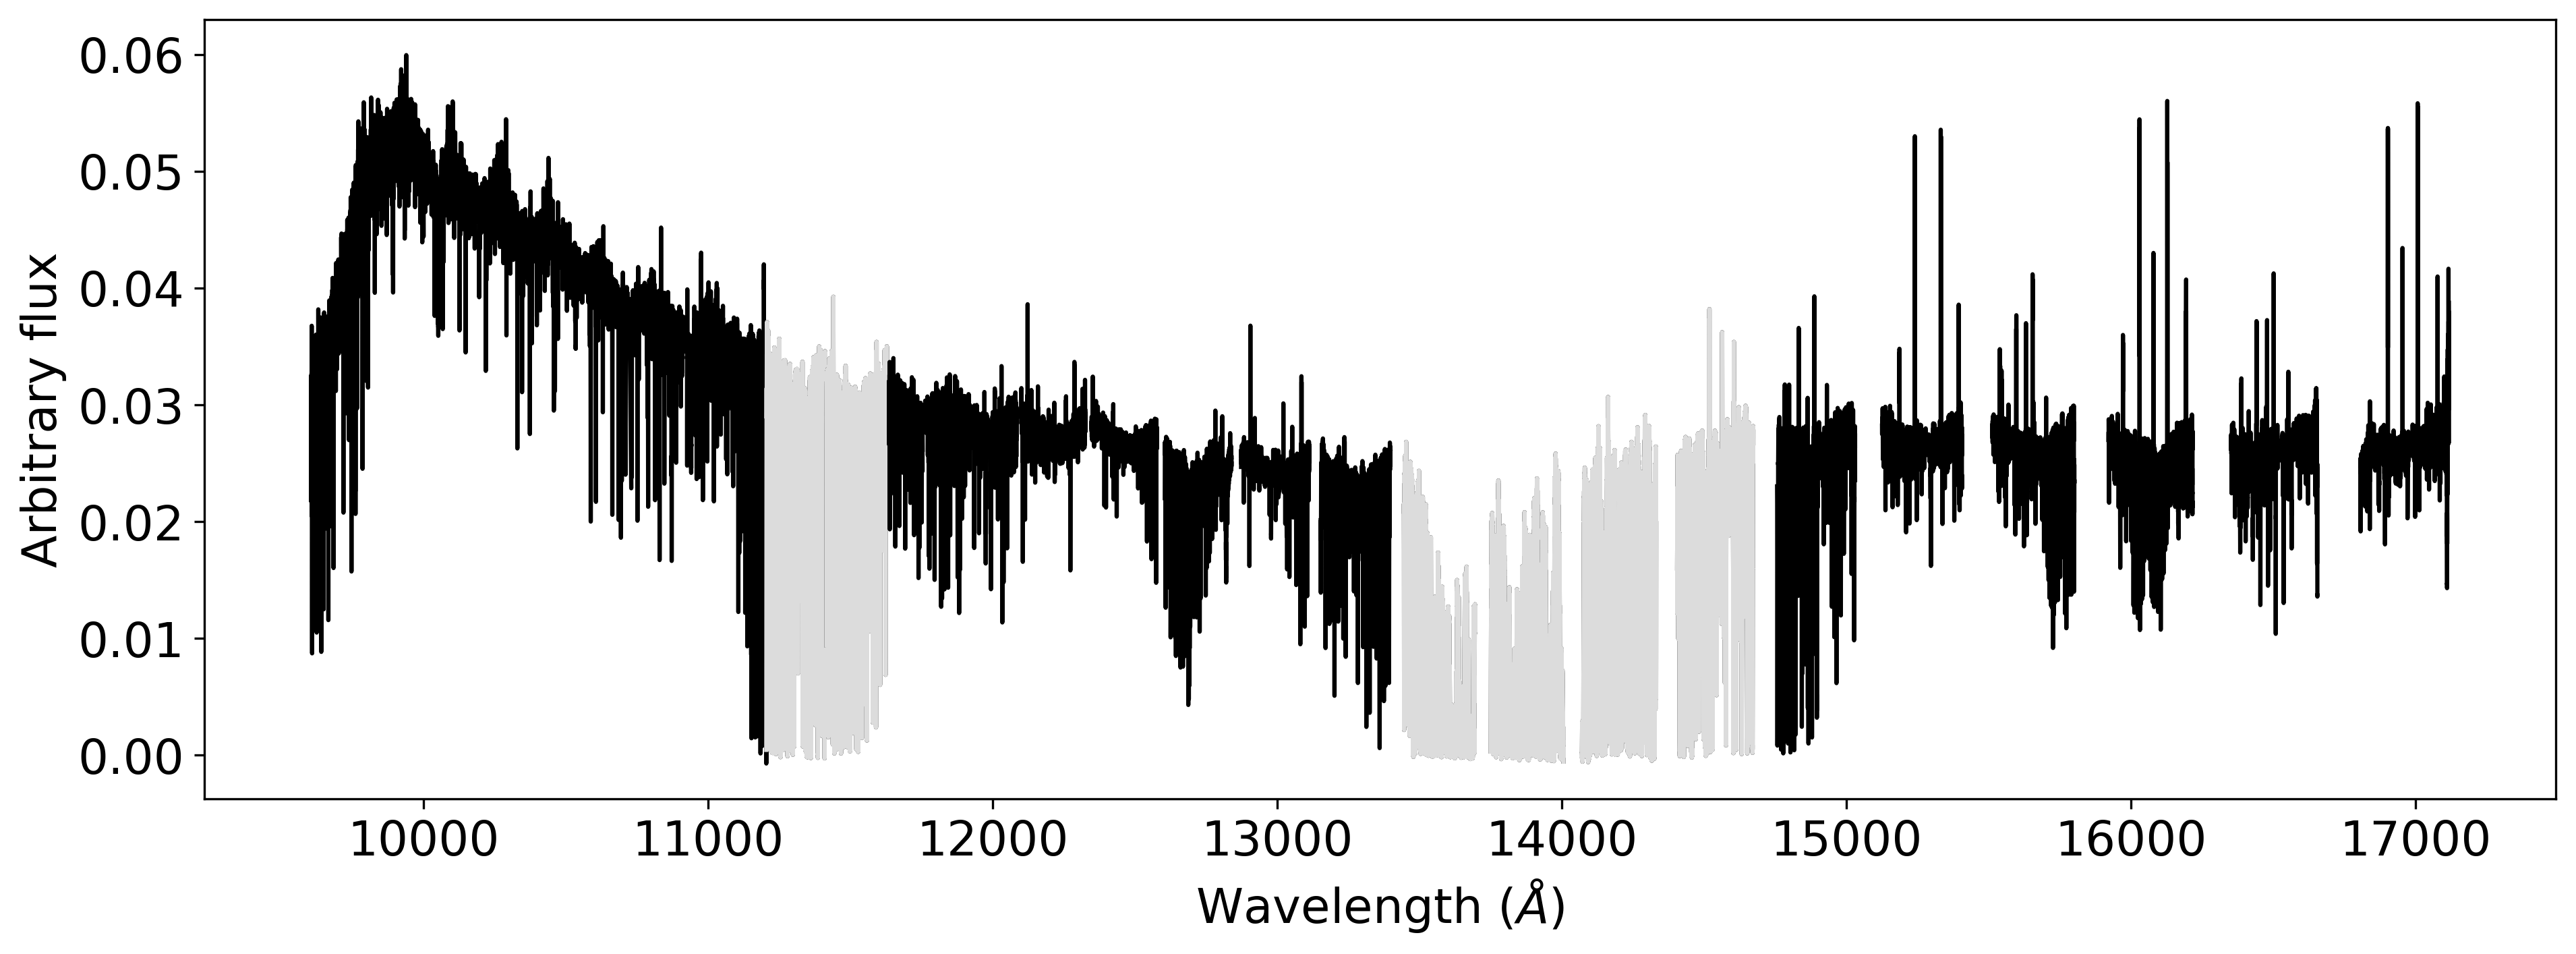

<Figure size 640x480 with 0 Axes>

In [4]:
plt.figure(figsize=(15,5),dpi=300)
lbl = 17
bad_order = [9,10,18,19,20,21]
frame = 32
for i in range(28):
    plt.plot(wave_star[i][frame],flux_star[i][frame],c='black')
    if i in bad_order:
        plt.plot(wave_star[i][frame],flux_star[i][frame],c='gainsboro',alpha=1.0)
plt.xlabel(r'Wavelength ($\AA$)',fontsize=lbl)
plt.ylabel('Arbitrary flux',fontsize=lbl)
plt.tick_params(axis='both', which='major', labelsize=lbl)

plt.savefig("figures/masked_orders.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
plt.show(block=False)
plt.clf()

## Wavelength Stability Check

In [5]:
# telluric_model = fits.open("skytable.fits")  # open the (vacuum) model retrieved from ESO SkyCalc and saved in FITS file (model already broadened by instrument PSF)
# wv_tel,flux_tel = [],[]
# for i in range(len(telluric_model[1].data)):
#     wv_tel.append(telluric_model[1].data[i][0])
#     flux_tel.append(telluric_model[1].data[i][4])
# wv_tel = np.array(wv_tel) * 10 # model in nm, converting to angstrom because data is in angstrom
# flux_tel = np.array(flux_tel)

# # convolve model with instrument PSF
# wv = np.arange(wv_tel[0],wv_tel[-1],0.01)
# fluxinst = interp1d(wv_tel,flux_tel,kind='cubic')(wv)
# flux_boradened = pyasl.instrBroadGaussFast(wv,fluxinst,80400)

# #saving model result to HDF5
# with h5py.File('data/hdf5/telluric-transmission-model-spectrum-80400-accurate.hdf5', 'w') as h5f_raw:
#     h5f_raw.create_dataset('flux',data=flux_boradened)
#     h5f_raw.create_dataset('wv',data=wv)

ESO SkyCalc model description used above. <br>
 <br>
Altitude: 2400 m above sea level (La Silla)             # the closest to Calar-Alto available in the calculator <br>
Airmass = 1.00                                          # based on the airmass of the highest-SNR frame <br>
Altitude = 84.2                                         # calculated automatically by the calculator based on the airmass <br>
Season: Apr/May                                         # comparing season and climate between Chile (La Silla) and Spain (Calar-Alto) <br>
Time period: Entire night                               # based on the observation time <br>
PWV = 10.00 mm                                          # based on the average humidity in Calar-Alto, ~7 mm (Sanchez-Lopez+ 2019) <br>
Monthly Averaged Solar Radio Flux: 130.00 sfu           # default value <br>

Range: 950.00 - 1800.00 nm <br>
Fixed R: 80,400 <br>
Wavelength: Vacuum <br>
LSF convolution kernel: None

(55, 28, 4080)


Frame:   0%|          | 0/55 [00:00<?, ?it/s]

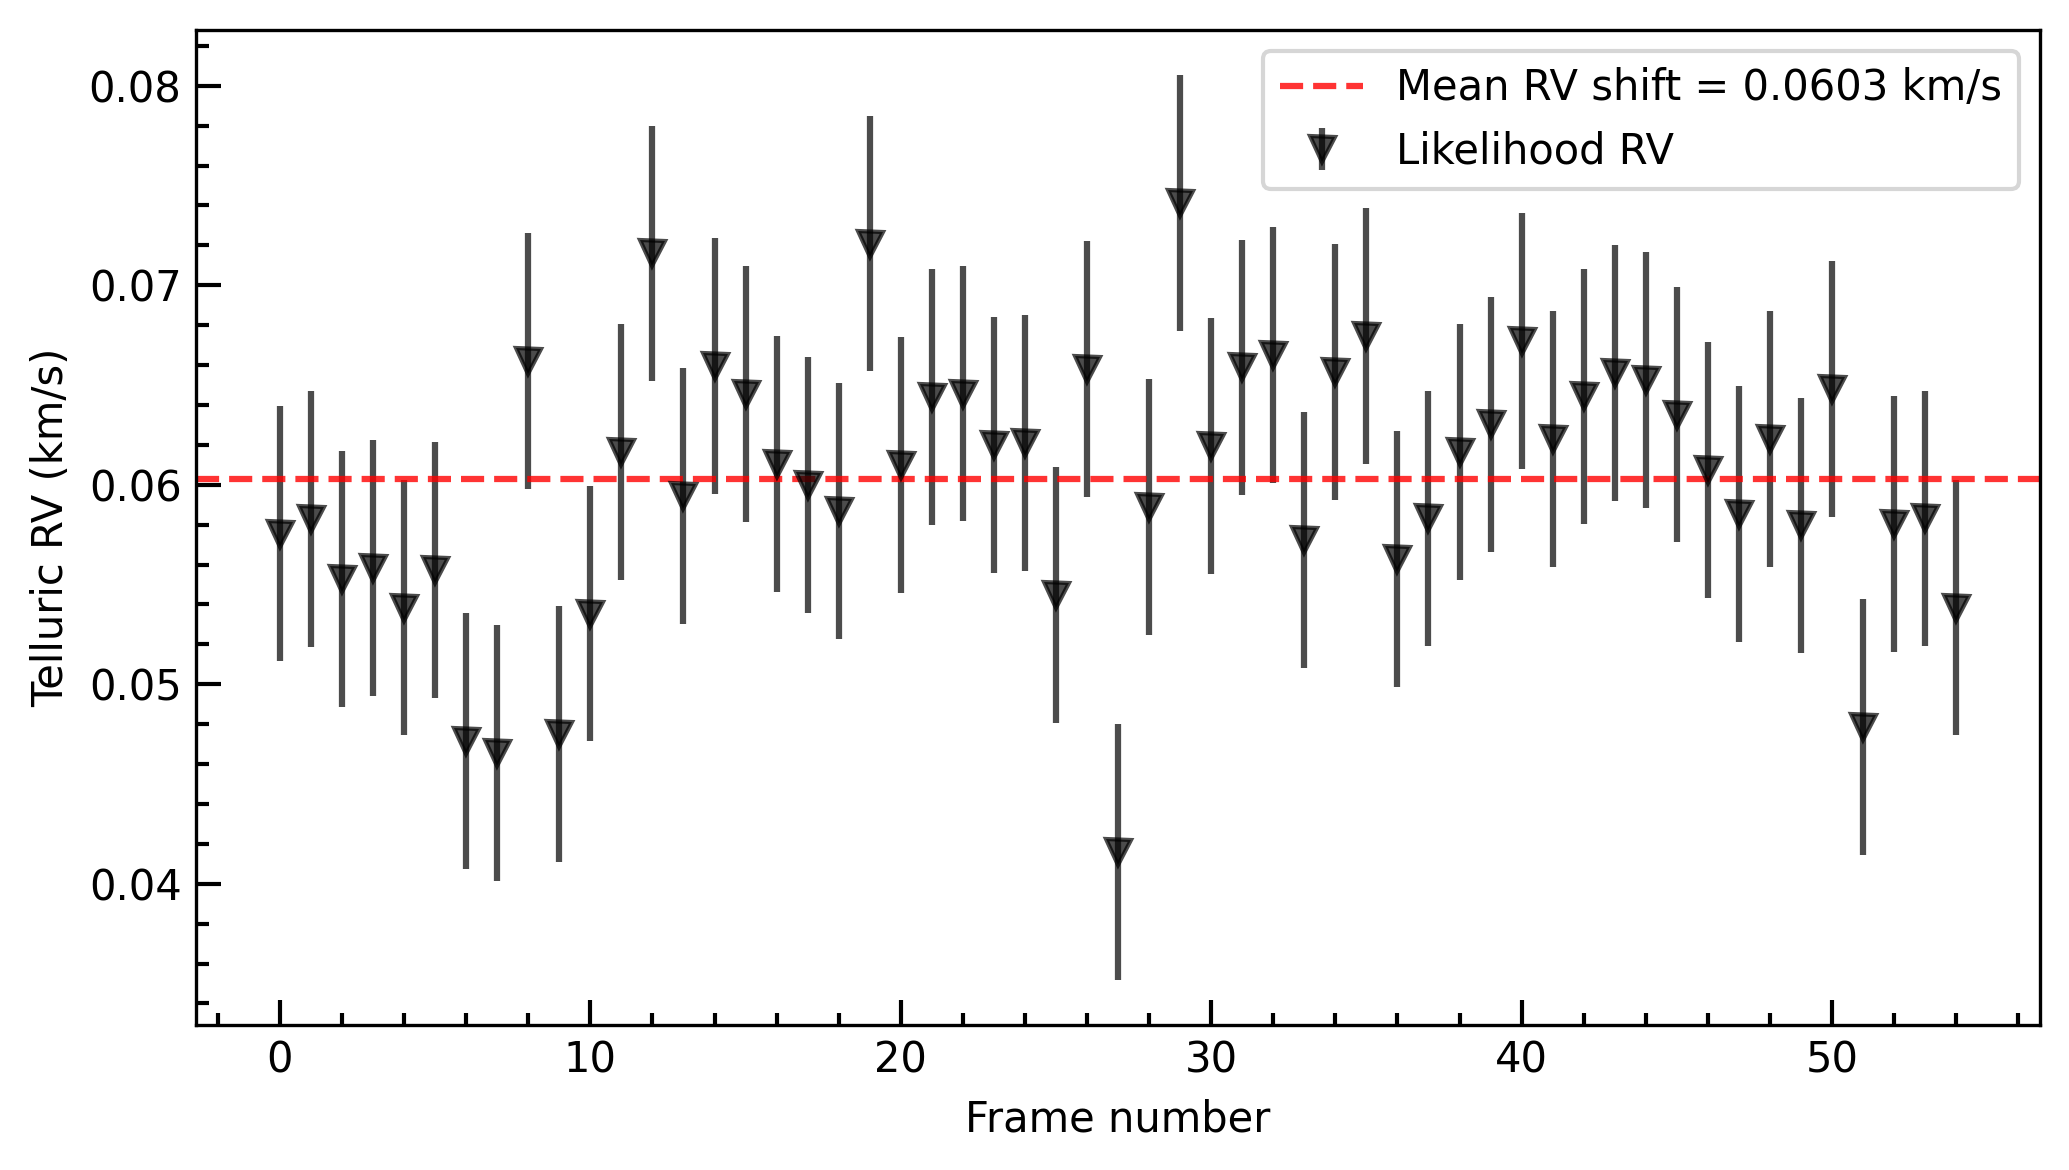

<Figure size 640x480 with 0 Axes>

In [6]:
# # telluric model path
# tel_model_path = 'data/hdf5/telluric-transmission-model-spectrum-80400-accurate.hdf5' # in vacuum
# RV_sample = np.arange(-2,2,0.001) # in km/s
# A_sample = np.arange(0.,1.5,0.0001)

# data.__dict__['plot_shift'] = False
# data.wave_stability_check(tel_model_path,RV_sample,A_sample)

# Light Curve

In [5]:
class Light_Curve():

    def __init__(self,BJD,**kwargs):
        self.__dict__.update(**kwargs)
        self.bjd = BJD

    def calc_LC(self,elliptic=True,plot=True):

        R_jup = const.R_jup.value # meter
        R_sun = const.R_sun.value # meter
        
        # defining batman parameters
        params = batman.TransitParams()                                         # object to store transit parameters
        params.t0 = self.__dict__['T0']                                         # time of inferior conjunction (BJD)
        params.per = self.__dict__['P']                                         # orbital period (days)
        params.rp = (self.__dict__['R_p']*R_jup)/(self.__dict__['R_s']*R_sun)     # planet radius (units of stellar radii)
        params.a = self.__dict__['ap']                                          # semi-major axis (units of stellar radii)
        params.inc = self.__dict__['inc']                                       # orbital inclination (degrees)
        params.ecc = self.__dict__['e']                                         # eccentricity
        params.w = self.__dict__['w']                                           # longitude of periastron (degrees)
        params.limb_dark = self.__dict__['limb_dark_model']                     # limb darkening model
        params.u = self.__dict__['limb_dark_coeff']                             # limb darkening coefficients

        time = np.array(self.bjd)
        model = batman.TransitModel(params,time)
        flux_batman = model.light_curve(params)

        # calculating phase and relative phase from mid-transit
        phase = (time - self.__dict__['T0'])/self.__dict__['P'] % 1
        relative_phase = []
        for ph in range(phase.size):
            relative_phase.append(phase[ph] - 1) if phase[ph] > 0.5 else relative_phase.append(phase[ph])
        hour_phase = np.array(relative_phase) * self.__dict__['P'] * 24 # in hour (assuming 24 hours a day)

        # mask for out-transit frames (outside ingress and egress)
        mask_out_transit = 1 - flux_batman
        for fl in range(flux_batman.size):
            if mask_out_transit[fl] != 0: mask_out_transit[fl] = 1 

        # transit weight for cross-correlation calculation
        transit_weight = (1. - flux_batman)/np.max(1. - flux_batman)
        
        ########## Estimating the time for first to fourth contact (calculated following Exoplanets, 2010) ##########

        ap, inc, e, w = self.__dict__['ap'],self.__dict__['inc'],self.__dict__['e'],self.__dict__['w']
        Tp, P, R_p, R_s = self.__dict__['Tp'],self.__dict__['P'],self.__dict__['R_p']*R_jup,self.__dict__['R_s']*R_sun

        b = ap * np.cos(math.radians(inc)) * (1 - e**2)\
            / (1 + e*np.sin(math.radians(w))) # impact parameter
        
        if elliptic:
            total_duration = P / np.pi * np.arcsin(1/ap * (np.sqrt((1+R_p/R_s)**2 - b**2))/(np.sin(math.radians(inc)))) # from first to fourth contact
            full_duration = P / np.pi * np.arcsin(1/ap * (np.sqrt((1-R_p/R_s)**2 - b**2))/(np.sin(math.radians(inc)))) # from second to third contact
            ingress_to_egress = (total_duration - full_duration)/2
        else:
            ingress_to_egress = P / (ap*np.pi) / np.sqrt(1-b**2) * R_p / R_s

        intrans_frame = []
        for idx in range(len(flux_batman)-1):
            if np.abs(flux_batman[idx]-flux_batman[idx+1]) > 0.:
                intrans_frame.append(idx)
        intrans_frame[-1] += 1 # to anticipate last index

        contact_time = [time[intrans_frame[0]], time[intrans_frame[0]]+ingress_to_egress,time[intrans_frame[-1]]-ingress_to_egress,time[intrans_frame[-1]]]
        contact_index = np.argmin(np.abs(time - np.asarray(contact_time)[:,np.newaxis]),axis=1)
        
        # calculate true anomaly
        phase_Tp = (np.array(self.bjd) - Tp)/P % 1
        M = (2 * np.pi * phase_Tp)
        E = np.zeros((len(M)))
        for i in range(len(E)):
            E[i] = solve_E(M[i],e)
        v_phase = np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2)) * 2 # in radians

        ###############################################################################################
        if plot:

            for idx,fl in enumerate(flux_batman):
                print("frame "+str(idx)+", bjd = "+str(time[idx])+", flux = "+str(flux_batman[idx]))

            print()
            print('Central transit:')
            print("Frame #"+str(np.argmin(flux_batman))+", BJD = "+str(time[np.argmin(flux_batman)])\
                +", Phase hours = "+str(hour_phase[np.argmin(flux_batman)])\
                    +", fluxmin = "+str(flux_batman[np.argmin(flux_batman)]))

            fig,ax1 = plt.subplots(figsize=(7,5),dpi=100)
            ax1.scatter(time,flux_batman,label=str(self.__dict__['limb_dark_model']))
            ax1.set_xlabel('BJD - 2400000')
            ax1.set_ylabel('Relative flux')
            ax1.axvline(x=contact_time[0],c='red',lw=1,alpha=0.5,ls='--')
            ax1.axvline(x=contact_time[1],c='red',lw=1,alpha=0.5,ls='--')
            ax1.axvline(x=contact_time[2],c='red',lw=1,alpha=0.5,ls='--')
            ax1.axvline(x=contact_time[3],c='red',lw=1,alpha=0.5,ls='--')
            # ax1.axvline(x=time[44],c='red',lw=1,alpha=0.5,ls='--')
            ax2 = ax1.twiny()
            ax2.scatter(hour_phase,flux_batman)
            ax2.set_xlabel('Hours from mid-transit')
            ax2.axvline(x=0,c='red',lw=1,alpha=0.5,ls='--')
            fig.tight_layout()
            plt.show()
            plt.clf()

            return flux_batman,phase,phase_Tp,relative_phase,hour_phase,v_phase,mask_out_transit,transit_weight,contact_index

frame 0, bjd = 58586.451700255275, flux = 1.0
frame 1, bjd = 58586.45488321688, flux = 1.0
frame 2, bjd = 58586.45807774784, flux = 1.0
frame 3, bjd = 58586.46256861696, flux = 1.0
frame 4, bjd = 58586.4657515781, flux = 1.0
frame 5, bjd = 58586.468922968954, flux = 1.0
frame 6, bjd = 58586.47385367006, flux = 1.0
frame 7, bjd = 58586.477025050204, flux = 1.0
frame 8, bjd = 58586.49857659591, flux = 1.0
frame 9, bjd = 58586.5017479863, flux = 1.0
frame 10, bjd = 58586.506400887854, flux = 0.9999738143044467
frame 11, bjd = 58586.50957227871, flux = 0.9992328204358286
frame 12, bjd = 58586.512755237985, flux = 0.9981479073892969
frame 13, bjd = 58586.51593819959, flux = 0.9971728581009226
frame 14, bjd = 58586.519121160265, flux = 0.9968789015078081
frame 15, bjd = 58586.52229255019, flux = 0.9967429167235413
frame 16, bjd = 58586.52681813855, flux = 0.9966107708530441
frame 17, bjd = 58586.529989528004, flux = 0.9965439398763201
frame 18, bjd = 58586.53316090768, flux = 0.9964913544899

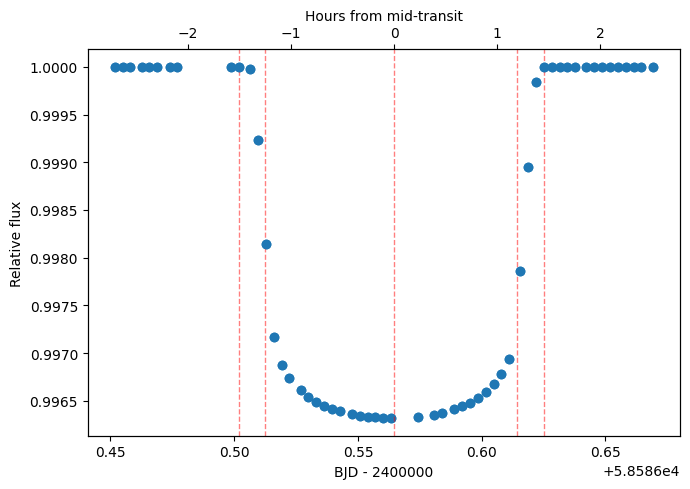

<Figure size 640x480 with 0 Axes>

In [6]:
# param for batman package
param = {} # case-sensitive

# convert BJD_UTC to BJD_TDB for T0
BJD_UTC = 54456.78760                           # transit midpoint, BJD_UTC-2400000 (Zhang+ 2018)
BJD_TDB = BJD_UTC + (32.184 + 34)/86400         # 34 is the number of leap seconds as of April 8th 2011 (Zhang data) since 1961
param['T0'] = BJD_TDB

# convert JD_UTC to BJD_TDB for Tp
JDUTC = astropy.time.Time(63208.799999999814+2400000, format='jd', scale='utc') # epoch of periastron in JD (Ment+ 2018)
# param['Tp'] = barycorrpy.utc_tdb.JDUTC_to_BJDTDB(JDUTC,starname='HD 149026', lat=37.2236, longi=-2.54625, alt=2168)[0][0] - 2400000
param['Tp'] = 63208.799999999814

param['P'] = 2.87588874                     # period, days (Zhang+ 2018)
param['R_p'] = 0.811                        # planet radius, Jupiter radii (Bonomo+ 2017)
param['R_s'] = 1.41                         # star radius, Sun radii (Stassun+ 2017)
semi_major = 0.04364                        # semi-major axis, AU (Bonomo+ 2017)
param['ap'] = semi_major*const.au.value\
    /(param['R_s']*const.R_sun.value)       # stellar radii
param['inc'] = 84.50                        # inclination, degrees (Bonomo+ 2017)
param['e'] = 0.0                              # eccentricity
param['w'] = -90                             # longitude of periastron, degrees
param['Vsys'] = -17.92

# calculated from https://exoctk.stsci.edu/limb_darkening using NIRSpec.F100LP.G140H.S200A1 bandpass
mu_nl = [0.619, -0.057,0.007,-0.024]        # non-linear limb darken
mu_qd = [0.075, 0.372]                      # quadratic limb darken
mu_lin = 0.39                               # linear limb darken
param['limb_dark_model'] = 'quadratic'
param['limb_dark_coeff'] = mu_qd

# convert JD_UTC to BJD_TDB for observations
# JDUTC = astropy.time.Time(data_info['JD']+2400000, format='jd', scale='utc')
# BJD_TDB_obs = barycorrpy.utc_tdb.JDUTC_to_BJDTDB(JDUTC,starname='HD 149026', lat=37.2236, longi=-2.54625, alt=2168)[0] - 2400000

lc = Light_Curve(data_info['BJD'],**param)
flux_batman,phase,phase_Tp,relative_phase,hour_phase,v_phase,mask_out_transit,transit_weight,contact_index = lc.calc_LC()

# Stellar RV Calculation

In [9]:
# reading model; model taken from PHOENIX database (choosing the closest stellar parameter as HD 149026) and convolved with instrument resolution

# with h5py.File('models/HD149026-PHOENIX-model-spectrum-80400-6200_45_p045_p00.hdf5', 'r') as h5f_raw:
#     modflux_phoenix = h5f_raw['flux'][()]
#     modwv_phoenix = h5f_raw['wv'][()]

# fig,ax = plt.subplots(22,1,figsize=(15,100))
# for order in range(22):
#     masktemp = (modwv_phoenix>wave[order][0][0]-20)*(modwv_phoenix<wave[order][0][-1]+20)
#     ax[order].plot(modwv_phoenix[masktemp], modflux_phoenix[masktemp])
#     ax[order].set_title(carm_order[order])

(55, 28, 4080)


Frame:   0%|          | 0/55 [00:00<?, ?it/s]

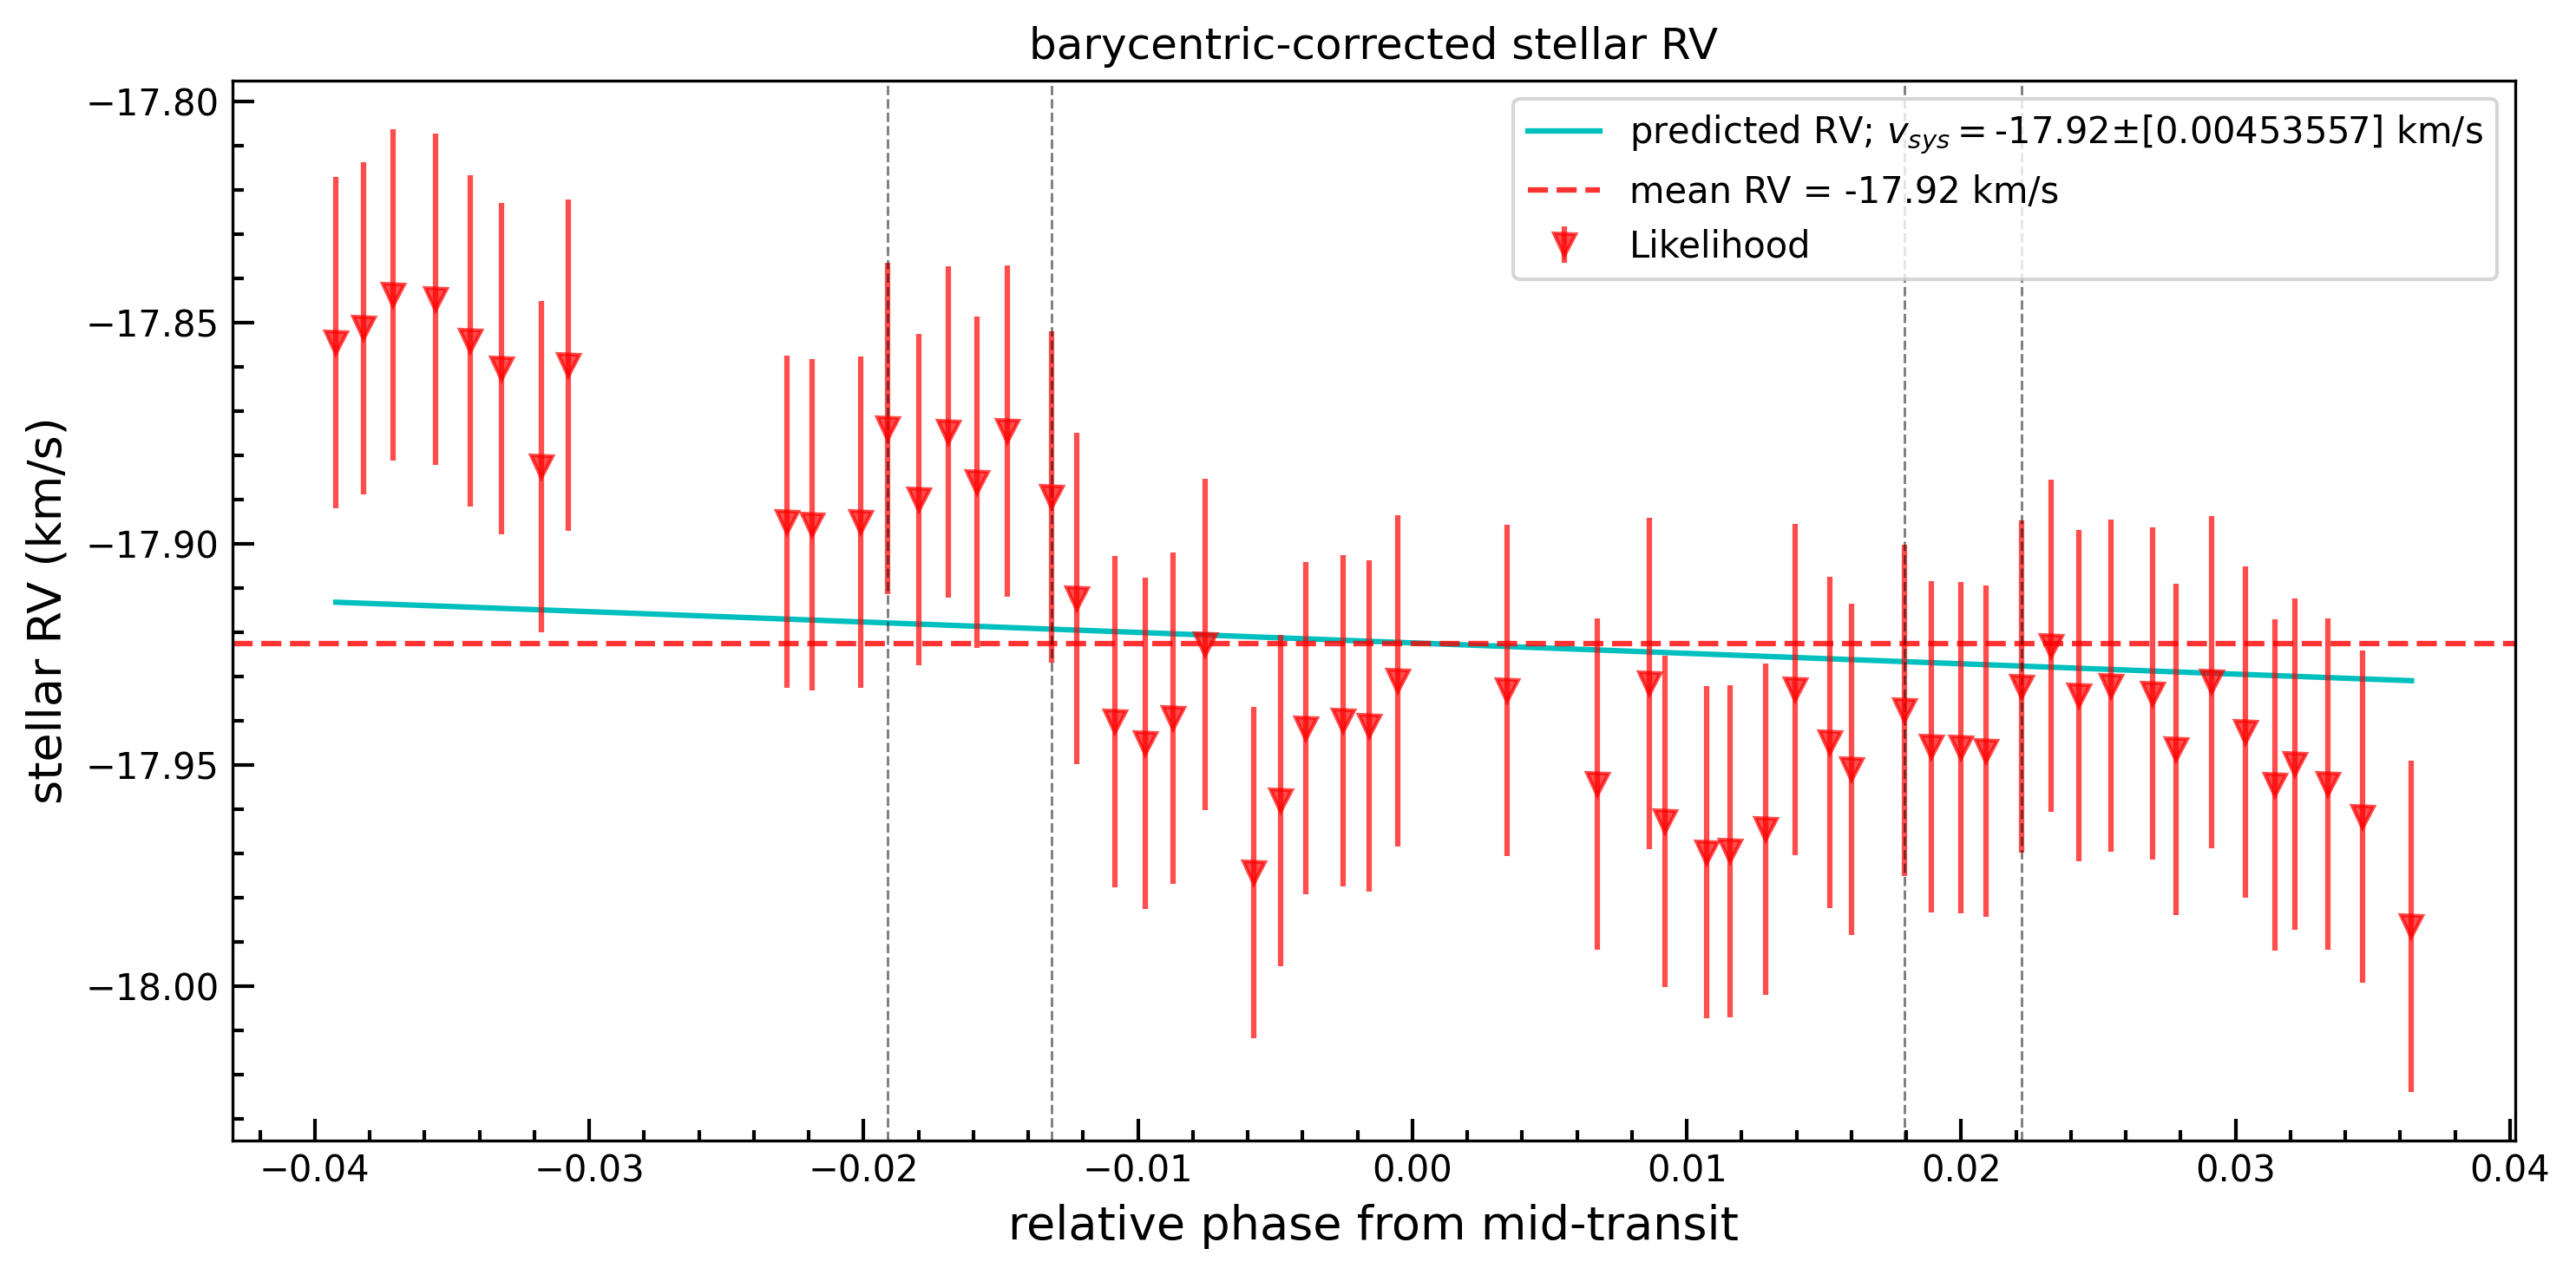

<Figure size 640x480 with 0 Axes>

In [10]:
# RV_sample = np.arange(-30,-20,0.01) # in km/s
# A_sample = np.arange(0.,2.,0.001)

# # input parameter
# P = 2.8758916                   # days, from Bonomo+ 2017
# inc = 84.50                     # degree, from Bonomo+ 2017
# e = 0.0
# Mp = 0.322                      # Jupiter mass, from Bonomo+ 2017
# Ms = 1.34                       # Sun mass, from Bonomo+ 2017
# Mj = const.M_jup.value          # kg
# Msun = const.M_sun.value        # kg
# param = [P, inc, Mp, Ms, Mj, Msun, e] # order --> [period, inclination, mass in Jupiter unit, mass in Sun unit, Jupiter mass in m, Sun mass in m, eccentricity]

# data.__dict__['plot_stellar_RV'] = False
# data.stellar_RV(modwv_phoenix, modflux_phoenix, RV_sample, A_sample, phase, relative_phase, *param)

# Saving Reduced Data

In [8]:
# saving results to HDF5 files

with h5py.File('data/hdf5/HD149026b-before-SYSREM-iteration-MJD_to_BJD-no_norm-no_masking.hdf5', 'w') as h5f_raw:

    for order in range(flux_star.shape[0]):

        # saving flux
        fluxdata = flux[order].copy()
        h5f_raw.create_dataset('flux-order-'+str(order),data=fluxdata)

        # saving the error estimated using outer product
        errdata = error_outer[order].copy()
        h5f_raw.create_dataset('error-outer-order-'+str(order),data=errdata)

        # saving the propagated photon noise from CARACAL
        errdata = error[order].copy()
        h5f_raw.create_dataset('error-poisson-order-'+str(order),data=errdata)

        # saving wavelength
        h5f_raw.create_dataset('wv-vac-order-'+str(order),data=wave[order])

    h5f_raw.create_dataset('airmass',data=data_info['airmass'])
    h5f_raw.create_dataset('rv_cor',data=data_info['RV_cor'])
    h5f_raw.create_dataset('bjd',data=data_info['BJD'])
    h5f_raw.create_dataset('mjd',data=data_info['MJD'])
    h5f_raw.create_dataset('jd',data=data_info['JD'])
    h5f_raw.create_dataset('exp_time',data=data_info['exptime'])
    h5f_raw.create_dataset('phase',data=phase)
    h5f_raw.create_dataset('rel_phase',data=relative_phase)
    h5f_raw.create_dataset('hour_phase',data=hour_phase)
    h5f_raw.create_dataset('v_phase',data=v_phase)
    h5f_raw.create_dataset('out_transit_mask',data=mask_out_transit)
    h5f_raw.create_dataset('transit_weight',data=transit_weight)
    h5f_raw.create_dataset('contact_index',data=contact_index)
    h5f_raw.create_dataset('carm_order',data=data_info['CARMENES_order'])

# SysRem

In [7]:
wave_sysrem, flux_sysrem, error_sysrem, maskpix = [], [], [], []
for idx,order in enumerate(data_info['CARMENES_order']):

    # removing masked pixels
    wave_temp,flux_temp,error_temp,mask = mask_pix(wave[idx],flux[idx],error_outer[idx])

    # calculate median spectrum
    median = np.nanmedian(flux_temp,axis=0)

    # normalize by median spectrum
    errnorm = np.array(error_temp)[:] / median
    fluxnorm = np.array(flux_temp)[:] / median

    wave_sysrem.append(np.array(wave_temp))
    flux_sysrem.append(fluxnorm)
    error_sysrem.append(errnorm)
    maskpix.append(mask)

sysrem_iteration = 10
fit_iteration = 20000
airmass = data_info['airmass']
data.flux_sysrem, data.error_sysrem, data.wave_sysrem = flux_sysrem.copy(),error_sysrem.copy(),wave_sysrem.copy() # case-sensitive

# running SysRem
a_model, c_model, sysrem_model, residual_flux, residual_error, residual_wave, outlier_count = data.SysRem(sysrem_iteration,airmass,fit_iteration,plot_sys=False)

# assigning the dimension of the original array
flux_final = np.zeros((flux.shape[0],sysrem_iteration+1,flux.shape[1],flux.shape[2]))
wave_final = flux_final.copy()
error_final = flux_final.copy()
error_final[:,:,:,:] = np.inf
a_final = np.array(a_model)
c_final = np.zeros((flux.shape[0],sysrem_iteration+1,flux.shape[2]))
for idx,order in enumerate(data_info['CARMENES_order']):
    for sysiter in range(sysrem_iteration+1):
        if sysiter != 0: c_final[idx][sysiter-1][maskpix[idx]==True] = c_model[idx][sysiter-1]
        for frame in range(flux_final.shape[2]):
            flux_final[idx][sysiter][frame][maskpix[idx]==True] = residual_flux[idx][sysiter][frame]
            error_final[idx][sysiter][frame][maskpix[idx]==True] = residual_error[idx][sysiter][frame]
            wave_final[idx][sysiter][frame] = wave[idx][frame]

Order:   0%|          | 0/22 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

Sysrem Iteration:   0%|          | 0/11 [00:00<?, ?it/s]

In [9]:
# saving results to HDF5 files

for sysiter in range(flux_final.shape[1]):

    # making hdf5 file for each SYSREM iteration
    with h5py.File('data/hdf5/HD149026b-after-#'+str(sysiter)+'-SYSREM-iteration-sys-MJD_to_BJD-woframe#44.hdf5', 'w') as h5f_raw:

        for order in range(flux_final.shape[0]):

            # saving flux
            fluxdata = flux_final[order][sysiter].copy()
            h5f_raw.create_dataset('flux-order-'+str(order),data=fluxdata)

            # saving the propagation of whatever error passed into SysRem
            errdata = error_final[order][sysiter].copy()
            h5f_raw.create_dataset('error-poisson-order-'+str(order),data=errdata)

            # saving wavelength
            h5f_raw.create_dataset('wv-vac-order-'+str(order),data=wave_final[order][sysiter])

            if sysiter != 0:

                # saving a and c coefficient
                h5f_raw.create_dataset('a-coeff-order-'+str(order),data=a_final[order][sysiter-1])
                h5f_raw.create_dataset('c-coeff-order-'+str(order),data=c_final[order][sysiter-1])

        h5f_raw.create_dataset('airmass',data=data_info['airmass'])
        h5f_raw.create_dataset('rv_cor',data=data_info['RV_cor'])
        h5f_raw.create_dataset('bjd',data=data_info['BJD'])
        h5f_raw.create_dataset('mjd',data=data_info['MJD'])
        h5f_raw.create_dataset('jd',data=data_info['JD'])
        h5f_raw.create_dataset('exp_time',data=data_info['exptime'])
        h5f_raw.create_dataset('carm_order',data=data_info['CARMENES_order'])
        h5f_raw.create_dataset('phase',data=phase)
        h5f_raw.create_dataset('rel_phase',data=relative_phase)
        h5f_raw.create_dataset('hour_phase',data=hour_phase)
        h5f_raw.create_dataset('v_phase',data=v_phase)
        h5f_raw.create_dataset('out_transit_mask',data=mask_out_transit)
        h5f_raw.create_dataset('transit_weight',data=transit_weight)
        h5f_raw.create_dataset('contact_index',data=contact_index)

# Plots for Paper

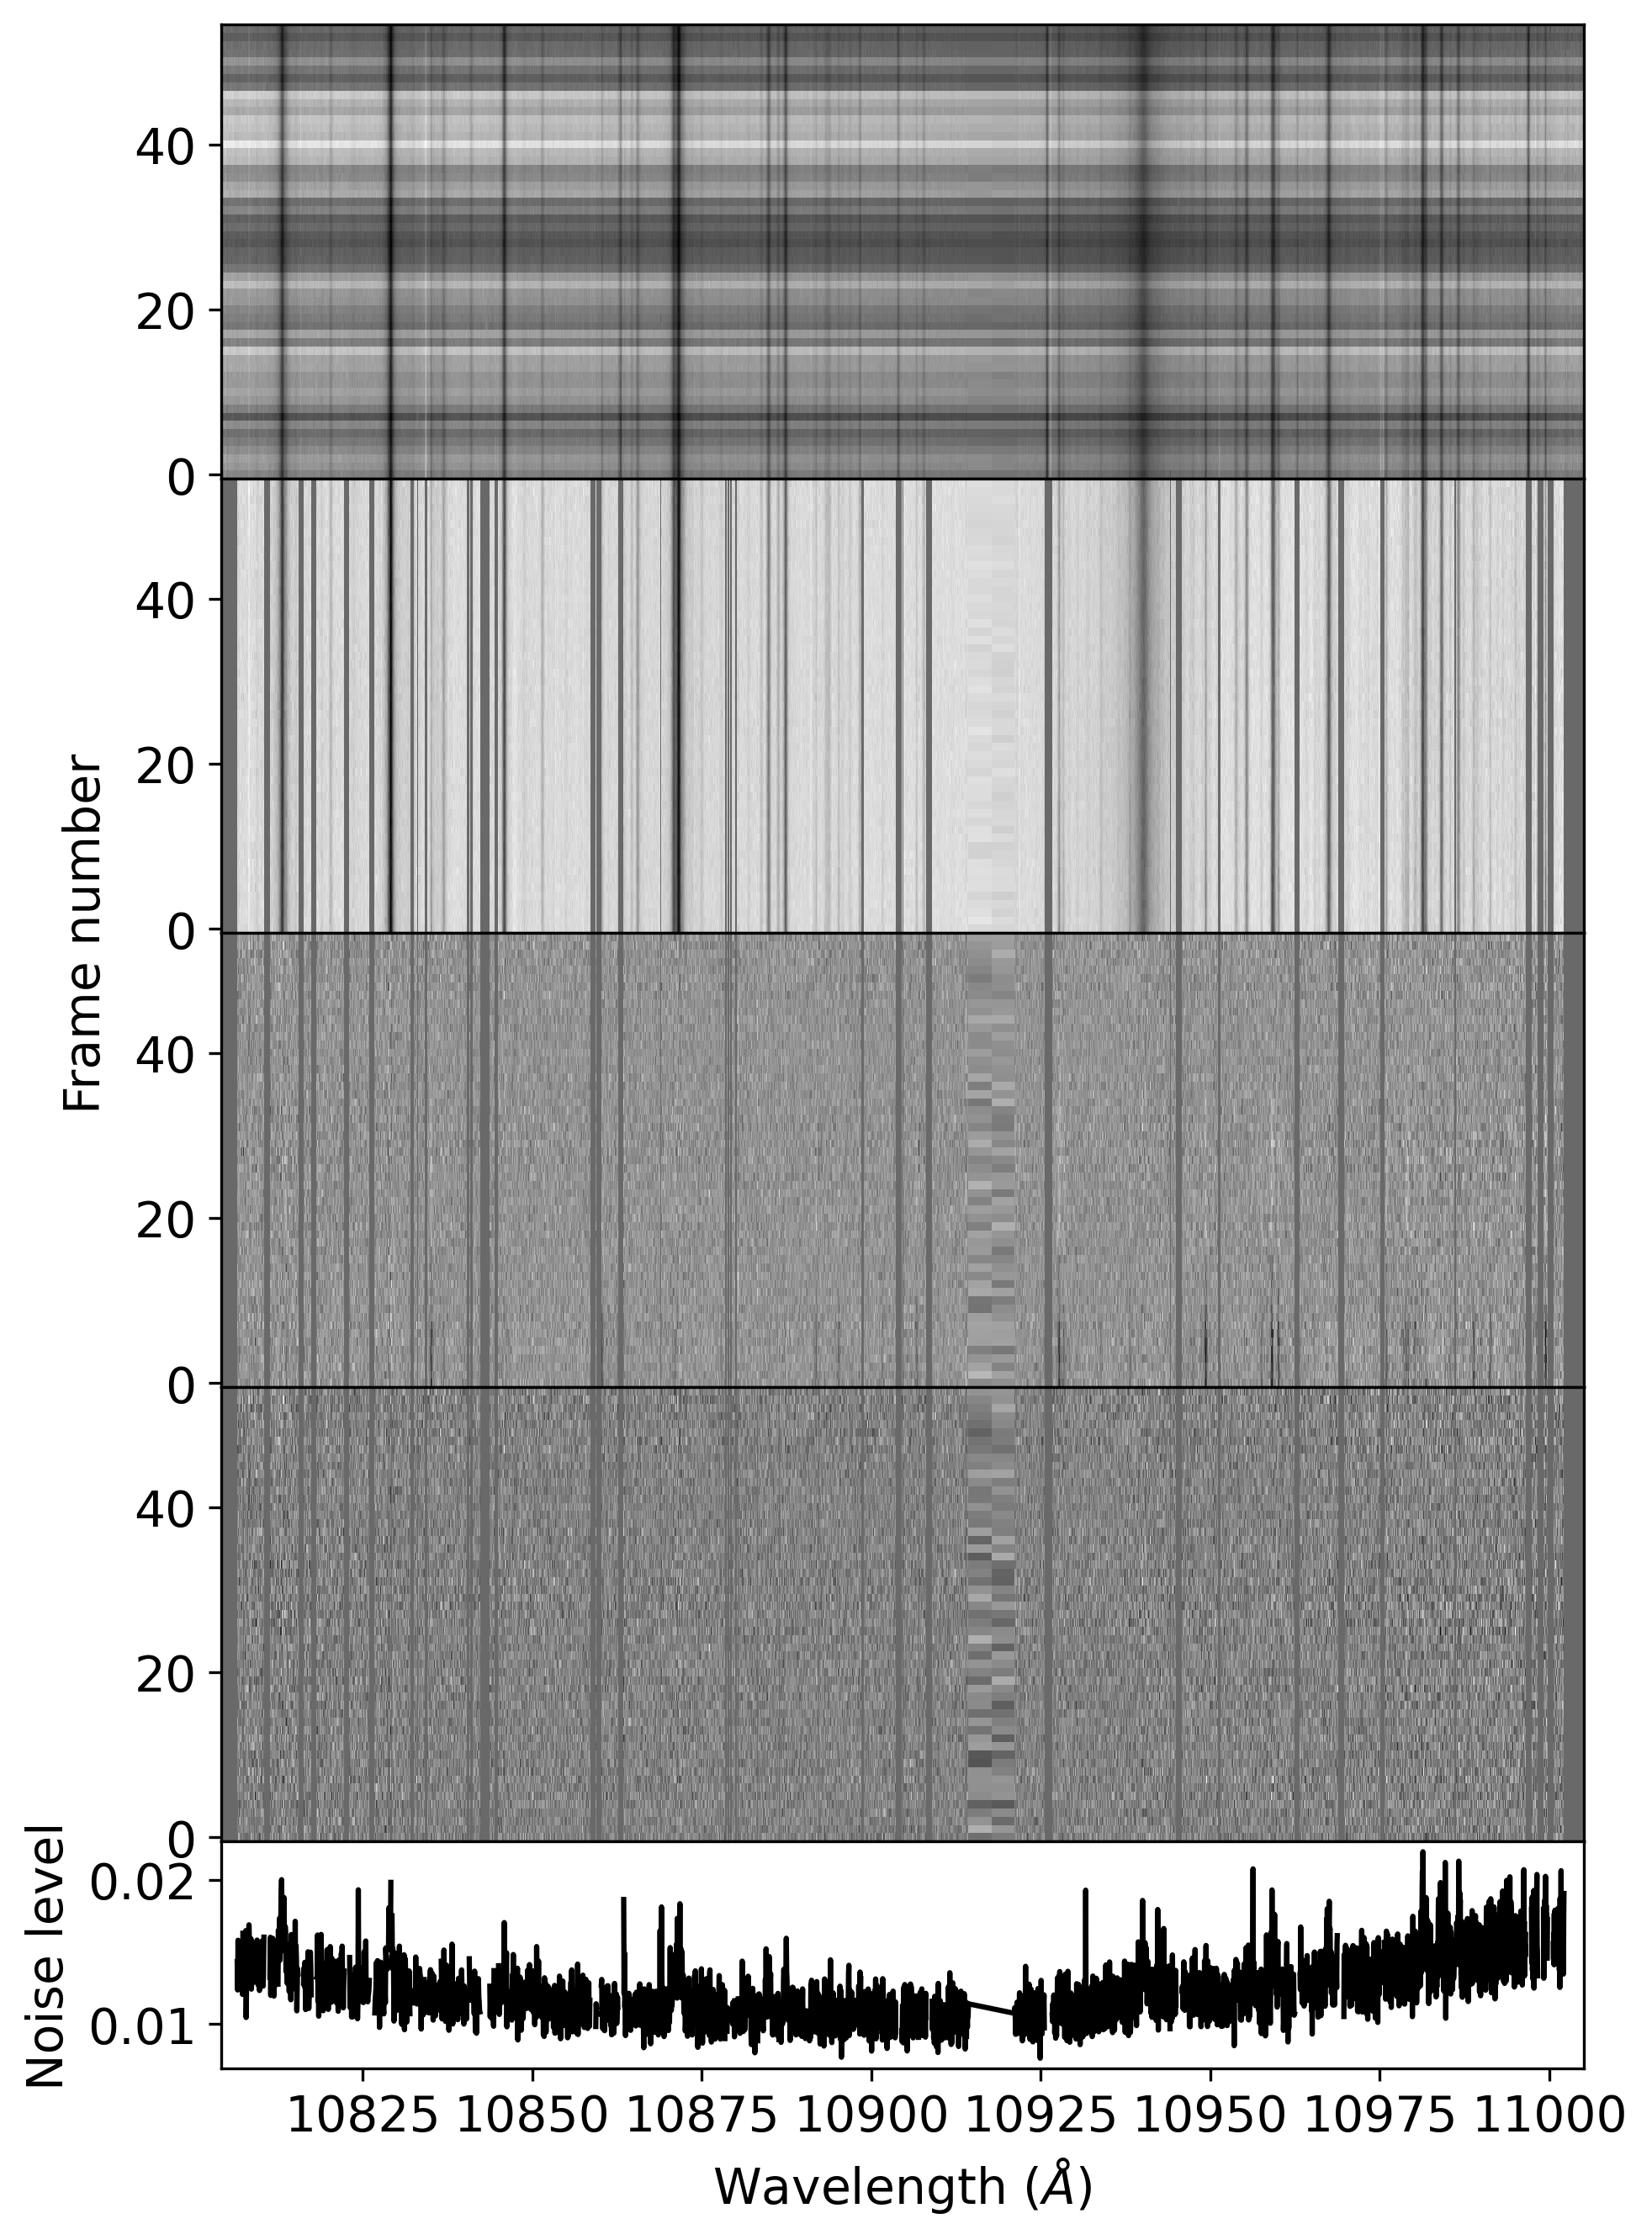

<Figure size 640x480 with 0 Axes>

In [15]:
# fl,er,wv, snr, airmass, humid, data_info  = data.data_prep()

for idx in range(flux_final.shape[0]):
    
    if idx == 7:
        
        colorm = 'gray'
        cmap = plt.get_cmap(colorm)
        cmap.set_bad(color = 'dimgrey', alpha = 1)

        lbl = 14

        order = data_info['CARMENES_order'][idx]

        axes_raw = [0,0+0.2+0.2+0.2,0.6,0.2]
        axes_prep = [0, 0+0.2+0.2, 0.6, 0.2]
        axes_norm = [0,0+0.2,0.6,0.2]
        axes_sys = [0,0,0.6,0.2]
        axes_frame = [0,0-0.1,0.6,0.1]

        fig = plt.figure(figsize=(9,9),dpi=300)
        raw = plt.axes(axes_raw)
        prep = plt.axes(axes_prep)
        norm = plt.axes(axes_norm)
        sys = plt.axes(axes_sys)
        fr = plt.axes(axes_frame)

        raw.set_xticklabels([])
        prep.set_xticklabels([])
        norm.set_xticklabels([])
        sys.set_xticklabels([])
        #fr.set_yticklabels([])

        fig.supylabel('Frame number',x=-0.07,y=0.4,fontsize=lbl)
        fr.set_xlabel(r'Wavelength ($\AA$)', fontsize=lbl)

        raw.pcolormesh(wv[order],np.arange(fl.shape[1]), fl[order],cmap=cmap)
        raw.set_xlim(wv[order][0][0],wv[order][0][-1])
        # raw.set_title("Spectral Order = "+str(order),size=14,weight="bold")
        # raw.set_title("Order 57",size=14,weight="bold")

        maskpix = mask_pix(wave[idx],flux[idx],error[idx])[3]
        fl_temp = flux[idx].copy()
        fl_temp[:,~maskpix] = np.nan
        prep.pcolormesh(wave[idx],np.arange(fl_temp.shape[0]),fl_temp,cmap=cmap)
        prep.set_xlabel('Wavelength ($\AA$)', fontsize=lbl)
        prep.set_xlim(wave[idx][0][0],wave[idx][0][-1])

        maskpix = mask_pix(wave[idx],flux[idx],error[idx])[3]
        fl_temp = flux[idx].copy()
        fl_temp[:,~maskpix] = np.nan
        fl_temp /= np.nanmedian(fl_temp,axis=0)
        norm.pcolormesh(wave[idx],np.arange(fl_temp.shape[0]),fl_temp,cmap=cmap)
        norm.set_xlabel('Wavelength ($\AA$)', fontsize=lbl)
        norm.set_xlim(wave[idx][0][0],wave[idx][0][-1])

        sys_num = 1
        maskpix = mask_pix(wave_final[idx][sys_num],flux_final[idx][sys_num],error_final[idx][sys_num])[3]
        fl_temp = flux_final[idx][sys_num].copy()
        fl_temp[:,~maskpix] = np.nan
        sys.pcolormesh(wave_final[idx][sys_num],np.arange(fl_temp.shape[0]),fl_temp,cmap=cmap)
        sys.set_xlabel('Wavelength ($\AA$)', fontsize=lbl)
        sys.set_xlim(wave[idx][0][0],wave[idx][0][-1])

        std = np.std(flux_final[idx][sys_num],axis=0)
        std[std == 0] = np.NaN
        fr.plot(wave_final[idx][sys_num][0],std,c='black')
        fr.set_xlabel('Wavelength ($\AA$)')
        fr.set_ylabel('Noise level',fontsize=lbl)
        fr.set_xlim(wave[idx][0][0],wave[idx][0][-1])
        

        raw.tick_params(axis='both', which='major', labelsize=lbl)
        prep.tick_params(axis='both', which='major', labelsize=lbl)
        fr.tick_params(axis='both', which='major', labelsize=lbl)
        sys.tick_params(axis='both', which='major', labelsize=lbl)
        norm.tick_params(axis='both', which='major', labelsize=lbl)

        plt.savefig("figures/analysis_steps.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
        plt.show(block=False)
        plt.clf()

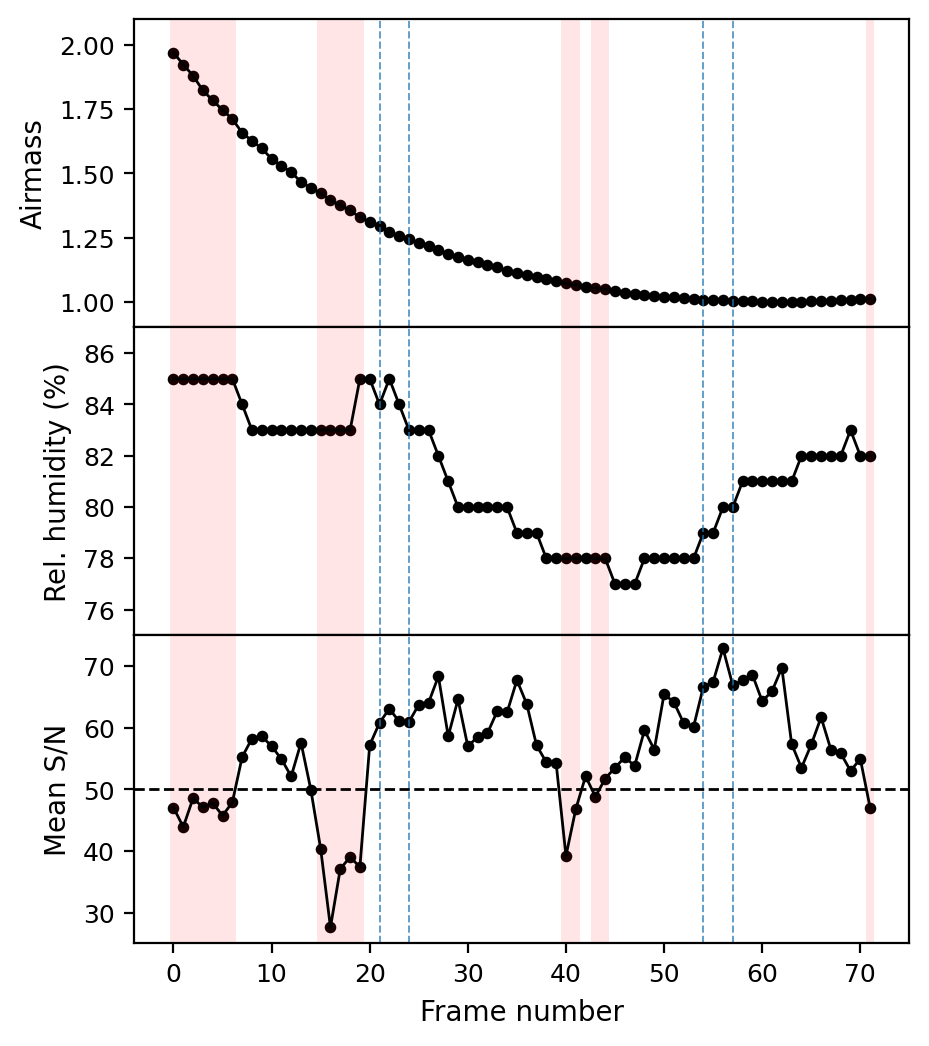

<Figure size 640x480 with 0 Axes>

In [11]:
# plotting S/N, airmass, and humidity as a funciton of time

fig,ax = plt.subplots(3,1,figsize=(5,6),dpi=200)
fig.subplots_adjust(hspace=0)

p = np.arange(100)
lbl = 10

ax[0].plot(airmass,lw=1,c='black')
ax[0].scatter(np.arange(len(airmass)),airmass,color='black',s=10)
ax[0].fill_betweenx(np.arange(76),-0.4,6.4,color='red',alpha=0.1,edgecolor='none')
ax[0].fill_betweenx(np.arange(76),14.6,19.4,color='red',alpha=0.1,edgecolor='none')
ax[0].fill_betweenx(np.arange(76),39.5,41.4,color='red',alpha=0.1,edgecolor='none')
ax[0].fill_betweenx(np.arange(76),42.6,44.4,color='red',alpha=0.1,edgecolor='none')
ax[0].fill_betweenx(np.arange(76),70.6,71.4,color='red',alpha=0.1,edgecolor='none')

ax[0].axvline(x=p[contact_index[0]],ls='--',lw=0.7,alpha=0.7)
ax[0].axvline(x=p[contact_index[1]],ls='--',lw=0.7,alpha=0.7)
ax[0].axvline(x=p[contact_index[2]],ls='--',lw=0.7,alpha=0.7)
ax[0].axvline(x=p[contact_index[3]],ls='--',lw=0.7,alpha=0.7)

ax[0].set_ylim(0.9,2.1)
ax[0].set_ylabel('Airmass', fontsize=lbl)

ax[1].plot(humid,lw=1,c='black')
ax[1].scatter(np.arange(len(humid)),humid,color='black',s=10)
ax[1].fill_betweenx(np.arange(100),-0.4,6.4,color='red',alpha=0.1,edgecolor='none')
ax[1].fill_betweenx(np.arange(100),14.6,19.4,color='red',alpha=0.1,edgecolor='none')
ax[1].fill_betweenx(np.arange(100),39.5,41.4,color='red',alpha=0.1,edgecolor='none')
ax[1].fill_betweenx(np.arange(100),42.6,44.4,color='red',alpha=0.1,edgecolor='none')
ax[1].fill_betweenx(np.arange(100),70.6,71.4,color='red',alpha=0.1,edgecolor='none')

ax[1].axvline(x=p[contact_index[0]],ls='--',lw=0.7,alpha=0.7)
ax[1].axvline(x=p[contact_index[1]],ls='--',lw=0.7,alpha=0.7)
ax[1].axvline(x=p[contact_index[2]],ls='--',lw=0.7,alpha=0.7)
ax[1].axvline(x=p[contact_index[3]],ls='--',lw=0.7,alpha=0.7)

ax[1].set_ylim(75,87)
ax[1].set_ylabel('Rel. humidity (%)', fontsize=lbl)

ax[2].plot(np.mean(snr,axis=1),lw=1,color='black')
ax[2].scatter(np.arange(len(snr)),np.mean(snr,axis=1),color='black',s=10)
# ax[2].plot(np.median(snr,axis=1),lw=1,color='green')
# ax[2].scatter(np.arange(len(snr)),np.median(snr,axis=1),color='green',s=10)
ax[2].fill_betweenx(np.arange(100),-0.4,6.4,color='red',alpha=0.1,edgecolor='none')
ax[2].fill_betweenx(np.arange(100),14.6,19.4,color='red',alpha=0.1,edgecolor='none')
ax[2].fill_betweenx(np.arange(100),39.5,41.4,color='red',alpha=0.1,edgecolor='none')
ax[2].fill_betweenx(np.arange(100),42.6,44.4,color='red',alpha=0.1,edgecolor='none')
ax[2].fill_betweenx(np.arange(100),70.6,71.4,color='red',alpha=0.1,edgecolor='none')

ax[2].axvline(x=p[contact_index[0]],ls='--',lw=0.7,alpha=0.7)
ax[2].axvline(x=p[contact_index[1]],ls='--',lw=0.7,alpha=0.7)
ax[2].axvline(x=p[contact_index[2]],ls='--',lw=0.7,alpha=0.7)
ax[2].axvline(x=p[contact_index[3]],ls='--',lw=0.7,alpha=0.7)

ax[2].axhline(y=50,ls='--',lw=1,c='black')
ax[2].set_ylim(25,75)
ax[2].set_ylabel('Mean S/N', fontsize=lbl)
ax[2].set_xlabel('Frame number',fontsize=lbl)

ax[0].tick_params(axis='both', which='major', labelsize=9)
ax[1].tick_params(axis='both', which='major', labelsize=9)
ax[2].tick_params(axis='both', which='major', labelsize=9)
# ax[2].axvline(x=44)

plt.savefig("figures/night_condition.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
plt.show(block=False)
plt.clf()